# Fun with language modelling

Если вы пропустили лекцию, то посмотрите слайды к ней — они где-то есть. Также полезно почитать:

* [Unreasonable effectiveness of RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) (Andrej Karpathy)
* [Официальный пример от PyTorch](https://github.com/pytorch/examples/tree/master/word_language_model)

Рекомендуется заранее всё прочитать, чтобы понять, что от вас хотят. При желании, можете переписать всё так, как подсказывает ваше сердце.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import sys
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Препроцессинг (3 балла)

Возьмите какие-нибудь сырые данные. Википедия, «Гарри Поттер», «Игра Престолов», тексты Монеточки, твиты Тинькова — что угодно.

Для простоты будем делать char-level модель. Выкиньте из текстов все ненужные символы (можете оставить только алфавит и, пунктуацию). Сопоставьте всем различным символам свой номер. Удобно это хранить просто в питоновском словаре (`char2idx`). Для генерации вам потребуется ещё и обратный словарь (`idx2char`). Вы что-то такое должны были писать на вступительной — можете просто переиспользовать код оттуда.

Заранее зарезервируйте айдишники под служебные символы: `<START>`, `<END>`, `<PAD>`, `<UNK>`.

Клёво будет написать отдельный класс, который делает токенизацию и детокенизацию.

In [ ]:
import re

class Vocab:
    def __init__(self, data):
        self.chars = tuple(set(data))
        '''self.chars = ('<PAD>', '<START>', '<END>', '<UNK>')
        self.chars += tuple(set(data))'''

        self.idx2char = dict(enumerate(self.chars))
        self.char2idx = {ch: ii for ii, ch in self.idx2char.items()}
        
    def tokenize(self, sequence):
        return [self.char2idx[char] for char in sequence]
    
    def detokenize(self, sequence):
        return ''.join([self.idx2char[idx] for idx in sequence])
    
    def __len__(self):
        return len(self.char2idx)

In [ ]:
from torch.utils.data import Dataset

seq_len = 50

class TextDataset(Dataset):
    def __init__(self, data_path, seq_len, min_len = 40, max_len = 150):
        self.data = self.read_data(data_path)
        self.min_len = min_len
        self.max_len = max_len
        self.seq_len = seq_len
        
        self.vocab = Vocab(self.data)
        # разделим данные на отдельные сэмплы для обучения
        #self.sequences = self.create_sequences(self.data)

        self.samples = torch.LongTensor(self.create_samples(self.data))

        '''for i in range(119):
            print(self.vocab.detokenize(self.sequences[1][i]))'''
            
        # sample = torch.LongTensor(sample) # сконвертируйте в LongTensor
    
    def __len__(self):
        return len(self.samples)
 
    def __getitem__(self, idx):
        return self.samples[idx][0], self.samples[idx][1]

    def read_data(self, data_path):
        with open(data_path, 'r') as f:
            data = f.read()
            prep_data = re.sub("[^А-Яа-я0-9!?.,\n()…—«» ]+", "", data)
        return prep_data


    def create_samples(self, data):
        samples = []
        counter = 0
        rest = len(data) % (self.seq_len+1)
        # print(req_len)
        data_slice = data[:len(data) - rest]
        # print(len(data_slice))
        for i in range(0, len(data_slice), self.seq_len+1):
            # print(i)
            #print(len(data)-num_of_samples)
            samples.append([])
            samples[counter].append(self.vocab.tokenize(data_slice[i:i+self.seq_len])) # 0-51 51-102
            # print(enough_data[i:i+self.seq_len])
            samples[counter].append(self.vocab.tokenize(data_slice[i+1:i+self.seq_len+1])) # 1-50 51-100
            # print(enough_data[i+1:i+self.seq_len+1])

            counter += 1
        return samples

    '''def create_samples(self):
        samples = []
        for sent_idx in range(len(self.sequences)):
            for seq_idx in range(1, len(self.sequences[sent_idx])):
                sample = []
                sample.append(self.sequences[sent_idx][seq_idx-1])
                sample.append(self.sequences[sent_idx][seq_idx])
                samples.append(sample)
                # sample = self.sequences[sent_idx][seq_idx-1]
                # target = self.sequences[sent_idx][seq_idx]
        return samples'''

    '''def create_sequences(self, data):
        sequences = []
        # делим на предложения
        sentences = re.split(r'(?<=[.!?…]) ', data)
        
        for idx in range(len(sentences)):
            sentence = sentences[idx]
            token_sentence = self.vocab.tokenize(sentence)
            sequences.append([])
            # делаем предложения нужной длины
            # if len(token_sentence) > self.min_len: 
            #     if len(token_sentence) < self.max_len:
            #         while len(token_sentence) < self.max_len: # паддинг до maxlen
            #             token_sentence.append(self.vocab.char2idx['<PAD>'])
            #     else:
            #         token_sentence = token_sentence[:self.max_len]

            # идем скользящим окном длиной seq_len
            for i in range(self.seq_len, len(token_sentence)):
                # select sequence of tokens
                seq = token_sentence[i-self.seq_len:i]
                # tensor_seq = torch.LongTensor(seq) # сконвертируйте в LongTensor
                sequences[idx].append(seq)
                # print(samples)
        return sequences'''


In [ ]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

Если у вас какой-то большой массив текста (скажем, статьи Википедии), вы можете просто нарезать из него кусочки фиксированной длины и так их подавать в модель.

Если же вы хотите приключений, то можно разбить этот текст на предложения (`nltk.sent_tokenize`), и тогда все примеры будут разной длины. По соображениям производительности, вы не хотите использовать самые длинные и самые короткие сэмплы, поэтому имеет смысл обрезать их по длине.

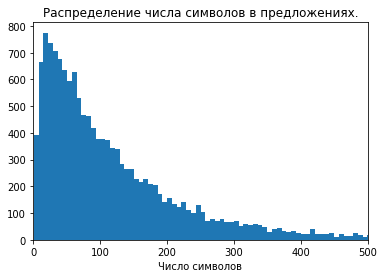

In [ ]:
plt.hist([len(x) for x in m], bins=350)
plt.title('Распределение числа символов в предложениях.')
plt.xlabel('Число символов')
plt.xlim((0, 500))
plt.show()

Разобьём на обучение и валидацию:

In [ ]:
dataset = TextDataset("/content/drive/MyDrive/Colab Notebooks/avidreaders.ru__anna-karenina.txt", seq_len=seq_len)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
dataset.__len__()

35116

In [ ]:
train_size

28092

## Модель (3 балла)

Примерно такое должно зайти:

* Эмбеддинг
* LSTM / GRU
* Линейный слой
* Softmax

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, tokens, n_hidden=256, n_layers=2, 
                 drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        # print(x.shape)
        r_output, hidden = self.lstm(x, hidden)
        
        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [ ]:
lr = 1e-3 
batch_size = 160

n_hidden=512
n_layers=3

net = CharRNN(dataset.vocab.chars, n_hidden, n_layers)

optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, drop_last=True)

## Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train(net, 
          train_loader, 
          test_loader, 
          optimizer, 
          criterion, 
          epochs=10, 
          seq_length=50, 
          clip=5, 
          val_frac=0.1, 
          print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    counter = 0
    n_chars = len(dataset.vocab.chars)
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size).to(device)
        total_predictions = np.array([])
        total_labels = np.array([])
        with tqdm(total=len(train_loader), file=sys.stdout) as prbar:
            for iter, (inputs, targets) in enumerate(train_loader):
                counter += 1
                
                # One-hot encode our data and make them Torch tensors
                # x = one_hot_encode(x, n_chars)
                # inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
                
                # if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()
                targets = targets.view(batch_size*seq_len).long().to(device)
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                # h = tuple([each.data for each in h])
                h = h.detach()
                # zero accumulated gradients
                net.zero_grad()
                
                # get the output from the model
                output, h = net(inputs, h)
                # print('out, hid shapes ', output.shape, h.shape)
                '''print('out ', output)
                print(output[0].shape)
                print('hid ', h)
                print(h[0].shape)
                print("out, hidden len", len(output), len(output[0]), len(h))'''

                # calculate the loss and perform backprop
                '''print("target shape", targets.view(batch_size*seq_length).long().shape)
                print('targer[0] shape', targets.view(batch_size*seq_length).long()[0])
                print(targets.view(batch_size*seq_length).long())'''
                loss = criterion(output, targets) # .view(batch_size*seq_length).long()
                loss.backward()

                '''accuracy = (output.argmax(1) == labels).float().mean()
                prbar.set_description(
                    f"Accuracy: {round(accuracy.item() * 100, 4)}"
                )
                prbar.update(1)'''
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(net.parameters(), clip)
                optimizer.step()
        
                # loss stats
                if counter % print_every == 0:
                    # Get validation loss
                    val_h = net.init_hidden(batch_size).to(device)
                    val_losses = []
                    net.eval()
                    # with tqdm(total=len(test_loader), file=sys.stdout) as prbar:
                    for iter, (x, y) in enumerate(test_loader):
                        # One-hot encode our data and make them Torch tensors
                        # x = one_hot_encode(x, n_chars)
                        # x, y = torch.from_numpy(x), torch.from_numpy(y)
                        
                        # Creating new variables for the hidden state, otherwise
                        # we'd backprop through the entire training history
                        # val_h = tuple([each.data for each in val_h])
                        
                        val_h = val_h.detach()

                        inputs, targets = x.cuda(), y.cuda()
                        # if(train_on_gpu):
                            # inputs, targets = inputs.cuda(), targets.cuda()
                        targets = targets.view(batch_size*seq_len).long().to(device)
                        output, val_h = net(inputs, val_h)
                        val_loss = criterion(output, targets) # .view(batch_size*seq_length).long()
                        val_losses.append(val_loss.item())

                        '''accuracy = (output.argmax(1) == labels).float().mean()
                        prbar.set_description(
                            f"Accuracy: {round(accuracy.item() * 100, 4)}"
                        )
                        prbar.update(1)
                        total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
                        total_labels = np.append(total_labels, labels.cpu().detach().numpy())'''
                    
                    net.train() # reset to train mode after iterationg through validation data
                    
                    print("Epoch: {}/{}...".format(e+1, epochs),
                        "Step: {}...".format(counter),
                        "Loss: {:.4f}...".format(loss.item()),
                        "Val Loss: {:.4f}".format(np.mean(val_losses))
                        )
                    '''metrics = {"loss": total_loss / num_batches}
                    metrics.update({"accuracy": (total_predictions == total_labels).mean()})'''

In [ ]:
n_epochs = 100
train(net, optimizer=optimizer, criterion=criterion, epochs=n_epochs, seq_length=seq_len, print_every=10)

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 1/100... Step: 10... Loss: 3.3806... Val Loss: 3.5373
Epoch: 1/100... Step: 20... Loss: 3.3370... Val Loss: 3.3113
Epoch: 1/100... Step: 30... Loss: 3.1473... Val Loss: 3.1181
Epoch: 1/100... Step: 40... Loss: 3.0122... Val Loss: 2.9964
Epoch: 1/100... Step: 50... Loss: 2.8835... Val Loss: 2.8659
Epoch: 1/100... Step: 60... Loss: 2.7669... Val Loss: 2.7550
Epoch: 1/100... Step: 70... Loss: 2.7059... Val Loss: 2.6745
Epoch: 1/100... Step: 80... Loss: 2.6175... Val Loss: 2.6136
Epoch: 1/100... Step: 90... Loss: 2.5645... Val Loss: 2.5668
Epoch: 1/100... Step: 100... Loss: 2.5462... Val Loss: 2.5300
Epoch: 1/100... Step: 110... Loss: 2.4911... Val Loss: 2.5005
Epoch: 1/100... Step: 120... Loss: 2.5069... Val Loss: 2.4729
Epoch: 1/100... Step: 130... Loss: 2.4944... Val Loss: 2.4517
Epoch: 1/100... Step: 140... Loss: 2.4383... Val Loss: 2.4277
Epoch: 1/100... Step: 150... Loss: 2.4064... Val Loss: 2.4072
Epoch: 1/100... Step: 160... Loss: 2.4263... Val Loss: 2.3851
Epoch: 1/100... S

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 2/100... Step: 180... Loss: 2.3486... Val Loss: 2.3428
Epoch: 2/100... Step: 190... Loss: 2.3493... Val Loss: 2.3227
Epoch: 2/100... Step: 200... Loss: 2.3289... Val Loss: 2.3003
Epoch: 2/100... Step: 210... Loss: 2.3171... Val Loss: 2.2811
Epoch: 2/100... Step: 220... Loss: 2.2798... Val Loss: 2.2593
Epoch: 2/100... Step: 230... Loss: 2.2856... Val Loss: 2.2394
Epoch: 2/100... Step: 240... Loss: 2.2305... Val Loss: 2.2188
Epoch: 2/100... Step: 250... Loss: 2.2354... Val Loss: 2.2010
Epoch: 2/100... Step: 260... Loss: 2.1955... Val Loss: 2.1810
Epoch: 2/100... Step: 270... Loss: 2.2074... Val Loss: 2.1633
Epoch: 2/100... Step: 280... Loss: 2.1637... Val Loss: 2.1430
Epoch: 2/100... Step: 290... Loss: 2.1454... Val Loss: 2.1251
Epoch: 2/100... Step: 300... Loss: 2.1706... Val Loss: 2.1082
Epoch: 2/100... Step: 310... Loss: 2.1493... Val Loss: 2.0934
Epoch: 2/100... Step: 320... Loss: 2.1219... Val Loss: 2.0761
Epoch: 2/100... Step: 330... Loss: 2.1071... Val Loss: 2.0599
Epoch: 2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 3/100... Step: 360... Loss: 2.0666... Val Loss: 2.0175
Epoch: 3/100... Step: 370... Loss: 2.0552... Val Loss: 2.0021
Epoch: 3/100... Step: 380... Loss: 2.0371... Val Loss: 1.9887
Epoch: 3/100... Step: 390... Loss: 2.0488... Val Loss: 1.9754
Epoch: 3/100... Step: 400... Loss: 2.0116... Val Loss: 1.9634
Epoch: 3/100... Step: 410... Loss: 1.9484... Val Loss: 1.9509
Epoch: 3/100... Step: 420... Loss: 2.0036... Val Loss: 1.9391
Epoch: 3/100... Step: 430... Loss: 1.9529... Val Loss: 1.9284
Epoch: 3/100... Step: 440... Loss: 1.9449... Val Loss: 1.9159
Epoch: 3/100... Step: 450... Loss: 1.9374... Val Loss: 1.9048
Epoch: 3/100... Step: 460... Loss: 1.8710... Val Loss: 1.8939
Epoch: 3/100... Step: 470... Loss: 1.9399... Val Loss: 1.8845
Epoch: 3/100... Step: 480... Loss: 1.9737... Val Loss: 1.8736
Epoch: 3/100... Step: 490... Loss: 1.8961... Val Loss: 1.8647
Epoch: 3/100... Step: 500... Loss: 1.9148... Val Loss: 1.8569
Epoch: 3/100... Step: 510... Loss: 1.9201... Val Loss: 1.8465
Epoch: 3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 4/100... Step: 530... Loss: 1.8495... Val Loss: 1.8297
Epoch: 4/100... Step: 540... Loss: 1.8819... Val Loss: 1.8216
Epoch: 4/100... Step: 550... Loss: 1.8703... Val Loss: 1.8122
Epoch: 4/100... Step: 560... Loss: 1.8778... Val Loss: 1.8061
Epoch: 4/100... Step: 570... Loss: 1.8111... Val Loss: 1.7971
Epoch: 4/100... Step: 580... Loss: 1.8340... Val Loss: 1.7898
Epoch: 4/100... Step: 590... Loss: 1.8146... Val Loss: 1.7812
Epoch: 4/100... Step: 600... Loss: 1.8199... Val Loss: 1.7769
Epoch: 4/100... Step: 610... Loss: 1.7923... Val Loss: 1.7676
Epoch: 4/100... Step: 620... Loss: 1.8349... Val Loss: 1.7614
Epoch: 4/100... Step: 630... Loss: 1.7815... Val Loss: 1.7535
Epoch: 4/100... Step: 640... Loss: 1.7600... Val Loss: 1.7470
Epoch: 4/100... Step: 650... Loss: 1.8518... Val Loss: 1.7415
Epoch: 4/100... Step: 660... Loss: 1.8123... Val Loss: 1.7362
Epoch: 4/100... Step: 670... Loss: 1.7895... Val Loss: 1.7311
Epoch: 4/100... Step: 680... Loss: 1.7754... Val Loss: 1.7262
Epoch: 4

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 5/100... Step: 710... Loss: 1.7658... Val Loss: 1.7110
Epoch: 5/100... Step: 720... Loss: 1.7700... Val Loss: 1.7068
Epoch: 5/100... Step: 730... Loss: 1.7532... Val Loss: 1.7014
Epoch: 5/100... Step: 740... Loss: 1.7611... Val Loss: 1.6952
Epoch: 5/100... Step: 750... Loss: 1.7512... Val Loss: 1.6909
Epoch: 5/100... Step: 760... Loss: 1.6950... Val Loss: 1.6855
Epoch: 5/100... Step: 770... Loss: 1.7438... Val Loss: 1.6810
Epoch: 5/100... Step: 780... Loss: 1.7163... Val Loss: 1.6762
Epoch: 5/100... Step: 790... Loss: 1.7022... Val Loss: 1.6716
Epoch: 5/100... Step: 800... Loss: 1.7015... Val Loss: 1.6672
Epoch: 5/100... Step: 810... Loss: 1.6523... Val Loss: 1.6636
Epoch: 5/100... Step: 820... Loss: 1.7213... Val Loss: 1.6595
Epoch: 5/100... Step: 830... Loss: 1.7352... Val Loss: 1.6558
Epoch: 5/100... Step: 840... Loss: 1.6702... Val Loss: 1.6534
Epoch: 5/100... Step: 850... Loss: 1.7181... Val Loss: 1.6502
Epoch: 5/100... Step: 860... Loss: 1.7118... Val Loss: 1.6478
Epoch: 5

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 6/100... Step: 880... Loss: 1.6600... Val Loss: 1.6382
Epoch: 6/100... Step: 890... Loss: 1.6921... Val Loss: 1.6359
Epoch: 6/100... Step: 900... Loss: 1.6866... Val Loss: 1.6325
Epoch: 6/100... Step: 910... Loss: 1.6964... Val Loss: 1.6318
Epoch: 6/100... Step: 920... Loss: 1.6438... Val Loss: 1.6267
Epoch: 6/100... Step: 930... Loss: 1.6752... Val Loss: 1.6241
Epoch: 6/100... Step: 940... Loss: 1.6432... Val Loss: 1.6207
Epoch: 6/100... Step: 950... Loss: 1.6485... Val Loss: 1.6184
Epoch: 6/100... Step: 960... Loss: 1.6351... Val Loss: 1.6152
Epoch: 6/100... Step: 970... Loss: 1.6788... Val Loss: 1.6114
Epoch: 6/100... Step: 980... Loss: 1.6355... Val Loss: 1.6090
Epoch: 6/100... Step: 990... Loss: 1.6160... Val Loss: 1.6063
Epoch: 6/100... Step: 1000... Loss: 1.7116... Val Loss: 1.6038
Epoch: 6/100... Step: 1010... Loss: 1.6615... Val Loss: 1.6010
Epoch: 6/100... Step: 1020... Loss: 1.6513... Val Loss: 1.6001
Epoch: 6/100... Step: 1030... Loss: 1.6457... Val Loss: 1.5978
Epoc

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 7/100... Step: 1060... Loss: 1.6239... Val Loss: 1.5890
Epoch: 7/100... Step: 1070... Loss: 1.6456... Val Loss: 1.5875
Epoch: 7/100... Step: 1080... Loss: 1.6288... Val Loss: 1.5869
Epoch: 7/100... Step: 1090... Loss: 1.6364... Val Loss: 1.5825
Epoch: 7/100... Step: 1100... Loss: 1.6365... Val Loss: 1.5821
Epoch: 7/100... Step: 1110... Loss: 1.5721... Val Loss: 1.5789
Epoch: 7/100... Step: 1120... Loss: 1.6243... Val Loss: 1.5774
Epoch: 7/100... Step: 1130... Loss: 1.6093... Val Loss: 1.5746
Epoch: 7/100... Step: 1140... Loss: 1.6019... Val Loss: 1.5732
Epoch: 7/100... Step: 1150... Loss: 1.5999... Val Loss: 1.5694
Epoch: 7/100... Step: 1160... Loss: 1.5304... Val Loss: 1.5689
Epoch: 7/100... Step: 1170... Loss: 1.6212... Val Loss: 1.5666
Epoch: 7/100... Step: 1180... Loss: 1.6363... Val Loss: 1.5648
Epoch: 7/100... Step: 1190... Loss: 1.5673... Val Loss: 1.5634
Epoch: 7/100... Step: 1200... Loss: 1.6101... Val Loss: 1.5623
Epoch: 7/100... Step: 1210... Loss: 1.6147... Val Loss:

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 8/100... Step: 1230... Loss: 1.5646... Val Loss: 1.5562
Epoch: 8/100... Step: 1240... Loss: 1.5977... Val Loss: 1.5549
Epoch: 8/100... Step: 1250... Loss: 1.5844... Val Loss: 1.5534
Epoch: 8/100... Step: 1260... Loss: 1.6079... Val Loss: 1.5525
Epoch: 8/100... Step: 1270... Loss: 1.5541... Val Loss: 1.5514
Epoch: 8/100... Step: 1280... Loss: 1.5929... Val Loss: 1.5494
Epoch: 8/100... Step: 1290... Loss: 1.5541... Val Loss: 1.5479
Epoch: 8/100... Step: 1300... Loss: 1.5641... Val Loss: 1.5461
Epoch: 8/100... Step: 1310... Loss: 1.5597... Val Loss: 1.5445
Epoch: 8/100... Step: 1320... Loss: 1.5892... Val Loss: 1.5419
Epoch: 8/100... Step: 1330... Loss: 1.5655... Val Loss: 1.5412
Epoch: 8/100... Step: 1340... Loss: 1.5231... Val Loss: 1.5396
Epoch: 8/100... Step: 1350... Loss: 1.6223... Val Loss: 1.5378
Epoch: 8/100... Step: 1360... Loss: 1.5907... Val Loss: 1.5365
Epoch: 8/100... Step: 1370... Loss: 1.5650... Val Loss: 1.5374
Epoch: 8/100... Step: 1380... Loss: 1.5681... Val Loss:

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 9/100... Step: 1410... Loss: 1.5555... Val Loss: 1.5309
Epoch: 9/100... Step: 1420... Loss: 1.5687... Val Loss: 1.5299
Epoch: 9/100... Step: 1430... Loss: 1.5566... Val Loss: 1.5299
Epoch: 9/100... Step: 1440... Loss: 1.5709... Val Loss: 1.5270
Epoch: 9/100... Step: 1450... Loss: 1.5656... Val Loss: 1.5265
Epoch: 9/100... Step: 1460... Loss: 1.5044... Val Loss: 1.5246
Epoch: 9/100... Step: 1470... Loss: 1.5493... Val Loss: 1.5253
Epoch: 9/100... Step: 1480... Loss: 1.5504... Val Loss: 1.5235
Epoch: 9/100... Step: 1490... Loss: 1.5338... Val Loss: 1.5225
Epoch: 9/100... Step: 1500... Loss: 1.5280... Val Loss: 1.5195
Epoch: 9/100... Step: 1510... Loss: 1.4711... Val Loss: 1.5197
Epoch: 9/100... Step: 1520... Loss: 1.5519... Val Loss: 1.5186
Epoch: 9/100... Step: 1530... Loss: 1.5543... Val Loss: 1.5175
Epoch: 9/100... Step: 1540... Loss: 1.5018... Val Loss: 1.5166
Epoch: 9/100... Step: 1550... Loss: 1.5543... Val Loss: 1.5166
Epoch: 9/100... Step: 1560... Loss: 1.5500... Val Loss:

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 10/100... Step: 1580... Loss: 1.5088... Val Loss: 1.5117
Epoch: 10/100... Step: 1590... Loss: 1.5411... Val Loss: 1.5118
Epoch: 10/100... Step: 1600... Loss: 1.5323... Val Loss: 1.5114
Epoch: 10/100... Step: 1610... Loss: 1.5449... Val Loss: 1.5105
Epoch: 10/100... Step: 1620... Loss: 1.4952... Val Loss: 1.5100
Epoch: 10/100... Step: 1630... Loss: 1.5270... Val Loss: 1.5087
Epoch: 10/100... Step: 1640... Loss: 1.4946... Val Loss: 1.5076
Epoch: 10/100... Step: 1650... Loss: 1.5040... Val Loss: 1.5062
Epoch: 10/100... Step: 1660... Loss: 1.5104... Val Loss: 1.5056
Epoch: 10/100... Step: 1670... Loss: 1.5356... Val Loss: 1.5037
Epoch: 10/100... Step: 1680... Loss: 1.5123... Val Loss: 1.5044
Epoch: 10/100... Step: 1690... Loss: 1.4718... Val Loss: 1.5035
Epoch: 10/100... Step: 1700... Loss: 1.5683... Val Loss: 1.5023
Epoch: 10/100... Step: 1710... Loss: 1.5348... Val Loss: 1.5009
Epoch: 10/100... Step: 1720... Loss: 1.5249... Val Loss: 1.5016
Epoch: 10/100... Step: 1730... Loss: 1.5

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 11/100... Step: 1760... Loss: 1.4972... Val Loss: 1.4976
Epoch: 11/100... Step: 1770... Loss: 1.5145... Val Loss: 1.4969
Epoch: 11/100... Step: 1780... Loss: 1.5008... Val Loss: 1.4972
Epoch: 11/100... Step: 1790... Loss: 1.5278... Val Loss: 1.4955
Epoch: 11/100... Step: 1800... Loss: 1.5099... Val Loss: 1.4947
Epoch: 11/100... Step: 1810... Loss: 1.4605... Val Loss: 1.4943
Epoch: 11/100... Step: 1820... Loss: 1.5079... Val Loss: 1.4949
Epoch: 11/100... Step: 1830... Loss: 1.4993... Val Loss: 1.4938
Epoch: 11/100... Step: 1840... Loss: 1.4828... Val Loss: 1.4928
Epoch: 11/100... Step: 1850... Loss: 1.4895... Val Loss: 1.4905
Epoch: 11/100... Step: 1860... Loss: 1.4320... Val Loss: 1.4911
Epoch: 11/100... Step: 1870... Loss: 1.5124... Val Loss: 1.4896
Epoch: 11/100... Step: 1880... Loss: 1.5086... Val Loss: 1.4896
Epoch: 11/100... Step: 1890... Loss: 1.4681... Val Loss: 1.4891
Epoch: 11/100... Step: 1900... Loss: 1.5041... Val Loss: 1.4903
Epoch: 11/100... Step: 1910... Loss: 1.5

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 12/100... Step: 1930... Loss: 1.4650... Val Loss: 1.4867
Epoch: 12/100... Step: 1940... Loss: 1.4926... Val Loss: 1.4866
Epoch: 12/100... Step: 1950... Loss: 1.4939... Val Loss: 1.4872
Epoch: 12/100... Step: 1960... Loss: 1.5010... Val Loss: 1.4854
Epoch: 12/100... Step: 1970... Loss: 1.4554... Val Loss: 1.4853
Epoch: 12/100... Step: 1980... Loss: 1.4781... Val Loss: 1.4836
Epoch: 12/100... Step: 1990... Loss: 1.4553... Val Loss: 1.4832
Epoch: 12/100... Step: 2000... Loss: 1.4707... Val Loss: 1.4823
Epoch: 12/100... Step: 2010... Loss: 1.4687... Val Loss: 1.4820
Epoch: 12/100... Step: 2020... Loss: 1.4994... Val Loss: 1.4806
Epoch: 12/100... Step: 2030... Loss: 1.4742... Val Loss: 1.4814
Epoch: 12/100... Step: 2040... Loss: 1.4306... Val Loss: 1.4813
Epoch: 12/100... Step: 2050... Loss: 1.5285... Val Loss: 1.4801
Epoch: 12/100... Step: 2060... Loss: 1.4946... Val Loss: 1.4792
Epoch: 12/100... Step: 2070... Loss: 1.4732... Val Loss: 1.4807
Epoch: 12/100... Step: 2080... Loss: 1.4

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 13/100... Step: 2110... Loss: 1.4672... Val Loss: 1.4776
Epoch: 13/100... Step: 2120... Loss: 1.4754... Val Loss: 1.4774
Epoch: 13/100... Step: 2130... Loss: 1.4626... Val Loss: 1.4771
Epoch: 13/100... Step: 2140... Loss: 1.4890... Val Loss: 1.4759
Epoch: 13/100... Step: 2150... Loss: 1.4773... Val Loss: 1.4763
Epoch: 13/100... Step: 2160... Loss: 1.4274... Val Loss: 1.4756
Epoch: 13/100... Step: 2170... Loss: 1.4611... Val Loss: 1.4767
Epoch: 13/100... Step: 2180... Loss: 1.4669... Val Loss: 1.4749
Epoch: 13/100... Step: 2190... Loss: 1.4554... Val Loss: 1.4744
Epoch: 13/100... Step: 2200... Loss: 1.4487... Val Loss: 1.4731
Epoch: 13/100... Step: 2210... Loss: 1.3940... Val Loss: 1.4739
Epoch: 13/100... Step: 2220... Loss: 1.4725... Val Loss: 1.4725
Epoch: 13/100... Step: 2230... Loss: 1.4703... Val Loss: 1.4730
Epoch: 13/100... Step: 2240... Loss: 1.4331... Val Loss: 1.4732
Epoch: 13/100... Step: 2250... Loss: 1.4756... Val Loss: 1.4735
Epoch: 13/100... Step: 2260... Loss: 1.4

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 14/100... Step: 2280... Loss: 1.4269... Val Loss: 1.4708
Epoch: 14/100... Step: 2290... Loss: 1.4519... Val Loss: 1.4708
Epoch: 14/100... Step: 2300... Loss: 1.4636... Val Loss: 1.4718
Epoch: 14/100... Step: 2310... Loss: 1.4781... Val Loss: 1.4703
Epoch: 14/100... Step: 2320... Loss: 1.4161... Val Loss: 1.4702
Epoch: 14/100... Step: 2330... Loss: 1.4494... Val Loss: 1.4691
Epoch: 14/100... Step: 2340... Loss: 1.4271... Val Loss: 1.4692
Epoch: 14/100... Step: 2350... Loss: 1.4456... Val Loss: 1.4679
Epoch: 14/100... Step: 2360... Loss: 1.4434... Val Loss: 1.4674
Epoch: 14/100... Step: 2370... Loss: 1.4667... Val Loss: 1.4667
Epoch: 14/100... Step: 2380... Loss: 1.4364... Val Loss: 1.4668
Epoch: 14/100... Step: 2390... Loss: 1.4030... Val Loss: 1.4674
Epoch: 14/100... Step: 2400... Loss: 1.4995... Val Loss: 1.4669
Epoch: 14/100... Step: 2410... Loss: 1.4704... Val Loss: 1.4670
Epoch: 14/100... Step: 2420... Loss: 1.4514... Val Loss: 1.4681
Epoch: 14/100... Step: 2430... Loss: 1.4

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 15/100... Step: 2460... Loss: 1.4293... Val Loss: 1.4653
Epoch: 15/100... Step: 2470... Loss: 1.4573... Val Loss: 1.4653
Epoch: 15/100... Step: 2480... Loss: 1.4306... Val Loss: 1.4655
Epoch: 15/100... Step: 2490... Loss: 1.4541... Val Loss: 1.4643
Epoch: 15/100... Step: 2500... Loss: 1.4496... Val Loss: 1.4651
Epoch: 15/100... Step: 2510... Loss: 1.3999... Val Loss: 1.4645
Epoch: 15/100... Step: 2520... Loss: 1.4404... Val Loss: 1.4655
Epoch: 15/100... Step: 2530... Loss: 1.4380... Val Loss: 1.4633
Epoch: 15/100... Step: 2540... Loss: 1.4231... Val Loss: 1.4633
Epoch: 15/100... Step: 2550... Loss: 1.4175... Val Loss: 1.4615
Epoch: 15/100... Step: 2560... Loss: 1.3674... Val Loss: 1.4635
Epoch: 15/100... Step: 2570... Loss: 1.4421... Val Loss: 1.4621
Epoch: 15/100... Step: 2580... Loss: 1.4397... Val Loss: 1.4627
Epoch: 15/100... Step: 2590... Loss: 1.3978... Val Loss: 1.4633
Epoch: 15/100... Step: 2600... Loss: 1.4453... Val Loss: 1.4643
Epoch: 15/100... Step: 2610... Loss: 1.4

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 16/100... Step: 2630... Loss: 1.4067... Val Loss: 1.4618
Epoch: 16/100... Step: 2640... Loss: 1.4271... Val Loss: 1.4615
Epoch: 16/100... Step: 2650... Loss: 1.4320... Val Loss: 1.4623
Epoch: 16/100... Step: 2660... Loss: 1.4393... Val Loss: 1.4615
Epoch: 16/100... Step: 2670... Loss: 1.3863... Val Loss: 1.4611
Epoch: 16/100... Step: 2680... Loss: 1.4174... Val Loss: 1.4603
Epoch: 16/100... Step: 2690... Loss: 1.3925... Val Loss: 1.4611
Epoch: 16/100... Step: 2700... Loss: 1.4137... Val Loss: 1.4598
Epoch: 16/100... Step: 2710... Loss: 1.4140... Val Loss: 1.4589
Epoch: 16/100... Step: 2720... Loss: 1.4421... Val Loss: 1.4590
Epoch: 16/100... Step: 2730... Loss: 1.4135... Val Loss: 1.4587
Epoch: 16/100... Step: 2740... Loss: 1.3753... Val Loss: 1.4589
Epoch: 16/100... Step: 2750... Loss: 1.4583... Val Loss: 1.4593
Epoch: 16/100... Step: 2760... Loss: 1.4272... Val Loss: 1.4590
Epoch: 16/100... Step: 2770... Loss: 1.4251... Val Loss: 1.4608
Epoch: 16/100... Step: 2780... Loss: 1.4

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 17/100... Step: 2810... Loss: 1.4006... Val Loss: 1.4591
Epoch: 17/100... Step: 2820... Loss: 1.4232... Val Loss: 1.4594
Epoch: 17/100... Step: 2830... Loss: 1.4147... Val Loss: 1.4592
Epoch: 17/100... Step: 2840... Loss: 1.4344... Val Loss: 1.4579
Epoch: 17/100... Step: 2850... Loss: 1.4270... Val Loss: 1.4585
Epoch: 17/100... Step: 2860... Loss: 1.3727... Val Loss: 1.4585
Epoch: 17/100... Step: 2870... Loss: 1.4155... Val Loss: 1.4598
Epoch: 17/100... Step: 2880... Loss: 1.4115... Val Loss: 1.4582
Epoch: 17/100... Step: 2890... Loss: 1.4083... Val Loss: 1.4580
Epoch: 17/100... Step: 2900... Loss: 1.3964... Val Loss: 1.4562
Epoch: 17/100... Step: 2910... Loss: 1.3391... Val Loss: 1.4583
Epoch: 17/100... Step: 2920... Loss: 1.4157... Val Loss: 1.4572
Epoch: 17/100... Step: 2930... Loss: 1.4094... Val Loss: 1.4587
Epoch: 17/100... Step: 2940... Loss: 1.3777... Val Loss: 1.4581
Epoch: 17/100... Step: 2950... Loss: 1.4242... Val Loss: 1.4586
Epoch: 17/100... Step: 2960... Loss: 1.4

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 18/100... Step: 2980... Loss: 1.3793... Val Loss: 1.4569
Epoch: 18/100... Step: 2990... Loss: 1.4057... Val Loss: 1.4570
Epoch: 18/100... Step: 3000... Loss: 1.4105... Val Loss: 1.4579
Epoch: 18/100... Step: 3010... Loss: 1.4228... Val Loss: 1.4568
Epoch: 18/100... Step: 3020... Loss: 1.3689... Val Loss: 1.4569
Epoch: 18/100... Step: 3030... Loss: 1.3964... Val Loss: 1.4560
Epoch: 18/100... Step: 3040... Loss: 1.3819... Val Loss: 1.4564
Epoch: 18/100... Step: 3050... Loss: 1.4039... Val Loss: 1.4562
Epoch: 18/100... Step: 3060... Loss: 1.3977... Val Loss: 1.4553
Epoch: 18/100... Step: 3070... Loss: 1.4241... Val Loss: 1.4552
Epoch: 18/100... Step: 3080... Loss: 1.3979... Val Loss: 1.4551
Epoch: 18/100... Step: 3090... Loss: 1.3492... Val Loss: 1.4557
Epoch: 18/100... Step: 3100... Loss: 1.4476... Val Loss: 1.4557
Epoch: 18/100... Step: 3110... Loss: 1.4139... Val Loss: 1.4562
Epoch: 18/100... Step: 3120... Loss: 1.4137... Val Loss: 1.4582
Epoch: 18/100... Step: 3130... Loss: 1.4

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 19/100... Step: 3160... Loss: 1.3878... Val Loss: 1.4555
Epoch: 19/100... Step: 3170... Loss: 1.3970... Val Loss: 1.4565
Epoch: 19/100... Step: 3180... Loss: 1.3930... Val Loss: 1.4559
Epoch: 19/100... Step: 3190... Loss: 1.4169... Val Loss: 1.4552
Epoch: 19/100... Step: 3200... Loss: 1.4024... Val Loss: 1.4556
Epoch: 19/100... Step: 3210... Loss: 1.3529... Val Loss: 1.4553
Epoch: 19/100... Step: 3220... Loss: 1.3908... Val Loss: 1.4559
Epoch: 19/100... Step: 3230... Loss: 1.3941... Val Loss: 1.4548
Epoch: 19/100... Step: 3240... Loss: 1.3819... Val Loss: 1.4563
Epoch: 19/100... Step: 3250... Loss: 1.3764... Val Loss: 1.4541
Epoch: 19/100... Step: 3260... Loss: 1.3273... Val Loss: 1.4555
Epoch: 19/100... Step: 3270... Loss: 1.3963... Val Loss: 1.4556
Epoch: 19/100... Step: 3280... Loss: 1.4031... Val Loss: 1.4553
Epoch: 19/100... Step: 3290... Loss: 1.3658... Val Loss: 1.4559
Epoch: 19/100... Step: 3300... Loss: 1.4035... Val Loss: 1.4554
Epoch: 19/100... Step: 3310... Loss: 1.4

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 20/100... Step: 3330... Loss: 1.3596... Val Loss: 1.4548
Epoch: 20/100... Step: 3340... Loss: 1.3835... Val Loss: 1.4546
Epoch: 20/100... Step: 3350... Loss: 1.4059... Val Loss: 1.4564
Epoch: 20/100... Step: 3360... Loss: 1.3999... Val Loss: 1.4556
Epoch: 20/100... Step: 3370... Loss: 1.3489... Val Loss: 1.4545
Epoch: 20/100... Step: 3380... Loss: 1.3674... Val Loss: 1.4542
Epoch: 20/100... Step: 3390... Loss: 1.3592... Val Loss: 1.4554
Epoch: 20/100... Step: 3400... Loss: 1.3803... Val Loss: 1.4551
Epoch: 20/100... Step: 3410... Loss: 1.3772... Val Loss: 1.4542
Epoch: 20/100... Step: 3420... Loss: 1.3980... Val Loss: 1.4540
Epoch: 20/100... Step: 3430... Loss: 1.3686... Val Loss: 1.4543
Epoch: 20/100... Step: 3440... Loss: 1.3283... Val Loss: 1.4543
Epoch: 20/100... Step: 3450... Loss: 1.4231... Val Loss: 1.4562
Epoch: 20/100... Step: 3460... Loss: 1.4012... Val Loss: 1.4550
Epoch: 20/100... Step: 3470... Loss: 1.3887... Val Loss: 1.4564
Epoch: 20/100... Step: 3480... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 21/100... Step: 3510... Loss: 1.3653... Val Loss: 1.4547
Epoch: 21/100... Step: 3520... Loss: 1.3815... Val Loss: 1.4559
Epoch: 21/100... Step: 3530... Loss: 1.3753... Val Loss: 1.4558
Epoch: 21/100... Step: 3540... Loss: 1.3920... Val Loss: 1.4550
Epoch: 21/100... Step: 3550... Loss: 1.3887... Val Loss: 1.4553
Epoch: 21/100... Step: 3560... Loss: 1.3350... Val Loss: 1.4547
Epoch: 21/100... Step: 3570... Loss: 1.3663... Val Loss: 1.4562
Epoch: 21/100... Step: 3580... Loss: 1.3694... Val Loss: 1.4546
Epoch: 21/100... Step: 3590... Loss: 1.3652... Val Loss: 1.4546
Epoch: 21/100... Step: 3600... Loss: 1.3680... Val Loss: 1.4533
Epoch: 21/100... Step: 3610... Loss: 1.3064... Val Loss: 1.4546
Epoch: 21/100... Step: 3620... Loss: 1.3831... Val Loss: 1.4555
Epoch: 21/100... Step: 3630... Loss: 1.3856... Val Loss: 1.4562
Epoch: 21/100... Step: 3640... Loss: 1.3379... Val Loss: 1.4562
Epoch: 21/100... Step: 3650... Loss: 1.3857... Val Loss: 1.4558
Epoch: 21/100... Step: 3660... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 22/100... Step: 3680... Loss: 1.3424... Val Loss: 1.4554
Epoch: 22/100... Step: 3690... Loss: 1.3481... Val Loss: 1.4551
Epoch: 22/100... Step: 3700... Loss: 1.3785... Val Loss: 1.4565
Epoch: 22/100... Step: 3710... Loss: 1.3851... Val Loss: 1.4563
Epoch: 22/100... Step: 3720... Loss: 1.3302... Val Loss: 1.4546
Epoch: 22/100... Step: 3730... Loss: 1.3590... Val Loss: 1.4550
Epoch: 22/100... Step: 3740... Loss: 1.3401... Val Loss: 1.4554
Epoch: 22/100... Step: 3750... Loss: 1.3680... Val Loss: 1.4561
Epoch: 22/100... Step: 3760... Loss: 1.3578... Val Loss: 1.4542
Epoch: 22/100... Step: 3770... Loss: 1.3835... Val Loss: 1.4547
Epoch: 22/100... Step: 3780... Loss: 1.3526... Val Loss: 1.4556
Epoch: 22/100... Step: 3790... Loss: 1.3249... Val Loss: 1.4555
Epoch: 22/100... Step: 3800... Loss: 1.4093... Val Loss: 1.4564
Epoch: 22/100... Step: 3810... Loss: 1.3747... Val Loss: 1.4558
Epoch: 22/100... Step: 3820... Loss: 1.3667... Val Loss: 1.4562
Epoch: 22/100... Step: 3830... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 23/100... Step: 3860... Loss: 1.3581... Val Loss: 1.4557
Epoch: 23/100... Step: 3870... Loss: 1.3609... Val Loss: 1.4566
Epoch: 23/100... Step: 3880... Loss: 1.3607... Val Loss: 1.4571
Epoch: 23/100... Step: 3890... Loss: 1.3814... Val Loss: 1.4554
Epoch: 23/100... Step: 3900... Loss: 1.3628... Val Loss: 1.4558
Epoch: 23/100... Step: 3910... Loss: 1.3311... Val Loss: 1.4558
Epoch: 23/100... Step: 3920... Loss: 1.3584... Val Loss: 1.4570
Epoch: 23/100... Step: 3930... Loss: 1.3620... Val Loss: 1.4553
Epoch: 23/100... Step: 3940... Loss: 1.3494... Val Loss: 1.4562
Epoch: 23/100... Step: 3950... Loss: 1.3463... Val Loss: 1.4547
Epoch: 23/100... Step: 3960... Loss: 1.3001... Val Loss: 1.4562
Epoch: 23/100... Step: 3970... Loss: 1.3664... Val Loss: 1.4563
Epoch: 23/100... Step: 3980... Loss: 1.3650... Val Loss: 1.4564
Epoch: 23/100... Step: 3990... Loss: 1.3256... Val Loss: 1.4575
Epoch: 23/100... Step: 4000... Loss: 1.3739... Val Loss: 1.4570
Epoch: 23/100... Step: 4010... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 24/100... Step: 4030... Loss: 1.3291... Val Loss: 1.4571
Epoch: 24/100... Step: 4040... Loss: 1.3539... Val Loss: 1.4566
Epoch: 24/100... Step: 4050... Loss: 1.3606... Val Loss: 1.4579
Epoch: 24/100... Step: 4060... Loss: 1.3688... Val Loss: 1.4583
Epoch: 24/100... Step: 4070... Loss: 1.3153... Val Loss: 1.4570
Epoch: 24/100... Step: 4080... Loss: 1.3491... Val Loss: 1.4573
Epoch: 24/100... Step: 4090... Loss: 1.3327... Val Loss: 1.4579
Epoch: 24/100... Step: 4100... Loss: 1.3467... Val Loss: 1.4590
Epoch: 24/100... Step: 4110... Loss: 1.3547... Val Loss: 1.4562
Epoch: 24/100... Step: 4120... Loss: 1.3681... Val Loss: 1.4559
Epoch: 24/100... Step: 4130... Loss: 1.3436... Val Loss: 1.4566
Epoch: 24/100... Step: 4140... Loss: 1.3045... Val Loss: 1.4572
Epoch: 24/100... Step: 4150... Loss: 1.3860... Val Loss: 1.4582
Epoch: 24/100... Step: 4160... Loss: 1.3705... Val Loss: 1.4583
Epoch: 24/100... Step: 4170... Loss: 1.3622... Val Loss: 1.4581
Epoch: 24/100... Step: 4180... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 25/100... Step: 4210... Loss: 1.3404... Val Loss: 1.4578
Epoch: 25/100... Step: 4220... Loss: 1.3527... Val Loss: 1.4578
Epoch: 25/100... Step: 4230... Loss: 1.3426... Val Loss: 1.4591
Epoch: 25/100... Step: 4240... Loss: 1.3769... Val Loss: 1.4577
Epoch: 25/100... Step: 4250... Loss: 1.3466... Val Loss: 1.4579
Epoch: 25/100... Step: 4260... Loss: 1.3208... Val Loss: 1.4580
Epoch: 25/100... Step: 4270... Loss: 1.3389... Val Loss: 1.4587
Epoch: 25/100... Step: 4280... Loss: 1.3440... Val Loss: 1.4578
Epoch: 25/100... Step: 4290... Loss: 1.3277... Val Loss: 1.4575
Epoch: 25/100... Step: 4300... Loss: 1.3404... Val Loss: 1.4556
Epoch: 25/100... Step: 4310... Loss: 1.2822... Val Loss: 1.4574
Epoch: 25/100... Step: 4320... Loss: 1.3531... Val Loss: 1.4580
Epoch: 25/100... Step: 4330... Loss: 1.3544... Val Loss: 1.4591
Epoch: 25/100... Step: 4340... Loss: 1.3109... Val Loss: 1.4598
Epoch: 25/100... Step: 4350... Loss: 1.3630... Val Loss: 1.4593
Epoch: 25/100... Step: 4360... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 26/100... Step: 4380... Loss: 1.3126... Val Loss: 1.4592
Epoch: 26/100... Step: 4390... Loss: 1.3307... Val Loss: 1.4584
Epoch: 26/100... Step: 4400... Loss: 1.3555... Val Loss: 1.4607
Epoch: 26/100... Step: 4410... Loss: 1.3515... Val Loss: 1.4602
Epoch: 26/100... Step: 4420... Loss: 1.3079... Val Loss: 1.4586
Epoch: 26/100... Step: 4430... Loss: 1.3388... Val Loss: 1.4591
Epoch: 26/100... Step: 4440... Loss: 1.3103... Val Loss: 1.4590
Epoch: 26/100... Step: 4450... Loss: 1.3361... Val Loss: 1.4601
Epoch: 26/100... Step: 4460... Loss: 1.3258... Val Loss: 1.4581
Epoch: 26/100... Step: 4470... Loss: 1.3555... Val Loss: 1.4578
Epoch: 26/100... Step: 4480... Loss: 1.3304... Val Loss: 1.4587
Epoch: 26/100... Step: 4490... Loss: 1.2971... Val Loss: 1.4587
Epoch: 26/100... Step: 4500... Loss: 1.3768... Val Loss: 1.4610
Epoch: 26/100... Step: 4510... Loss: 1.3528... Val Loss: 1.4611
Epoch: 26/100... Step: 4520... Loss: 1.3331... Val Loss: 1.4605
Epoch: 26/100... Step: 4530... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 27/100... Step: 4560... Loss: 1.3241... Val Loss: 1.4603
Epoch: 27/100... Step: 4570... Loss: 1.3401... Val Loss: 1.4597
Epoch: 27/100... Step: 4580... Loss: 1.3388... Val Loss: 1.4609
Epoch: 27/100... Step: 4590... Loss: 1.3562... Val Loss: 1.4601
Epoch: 27/100... Step: 4600... Loss: 1.3288... Val Loss: 1.4598
Epoch: 27/100... Step: 4610... Loss: 1.2958... Val Loss: 1.4596
Epoch: 27/100... Step: 4620... Loss: 1.3278... Val Loss: 1.4610
Epoch: 27/100... Step: 4630... Loss: 1.3297... Val Loss: 1.4597
Epoch: 27/100... Step: 4640... Loss: 1.3288... Val Loss: 1.4602
Epoch: 27/100... Step: 4650... Loss: 1.3250... Val Loss: 1.4581
Epoch: 27/100... Step: 4660... Loss: 1.2684... Val Loss: 1.4591
Epoch: 27/100... Step: 4670... Loss: 1.3337... Val Loss: 1.4600
Epoch: 27/100... Step: 4680... Loss: 1.3386... Val Loss: 1.4607
Epoch: 27/100... Step: 4690... Loss: 1.3063... Val Loss: 1.4629
Epoch: 27/100... Step: 4700... Loss: 1.3545... Val Loss: 1.4613
Epoch: 27/100... Step: 4710... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 28/100... Step: 4730... Loss: 1.3023... Val Loss: 1.4619
Epoch: 28/100... Step: 4740... Loss: 1.3260... Val Loss: 1.4608
Epoch: 28/100... Step: 4750... Loss: 1.3384... Val Loss: 1.4618
Epoch: 28/100... Step: 4760... Loss: 1.3575... Val Loss: 1.4617
Epoch: 28/100... Step: 4770... Loss: 1.2890... Val Loss: 1.4604
Epoch: 28/100... Step: 4780... Loss: 1.3240... Val Loss: 1.4612
Epoch: 28/100... Step: 4790... Loss: 1.3076... Val Loss: 1.4613
Epoch: 28/100... Step: 4800... Loss: 1.3243... Val Loss: 1.4631
Epoch: 28/100... Step: 4810... Loss: 1.3362... Val Loss: 1.4607
Epoch: 28/100... Step: 4820... Loss: 1.3437... Val Loss: 1.4605
Epoch: 28/100... Step: 4830... Loss: 1.3187... Val Loss: 1.4613
Epoch: 28/100... Step: 4840... Loss: 1.2872... Val Loss: 1.4627
Epoch: 28/100... Step: 4850... Loss: 1.3702... Val Loss: 1.4628
Epoch: 28/100... Step: 4860... Loss: 1.3362... Val Loss: 1.4633
Epoch: 28/100... Step: 4870... Loss: 1.3308... Val Loss: 1.4639
Epoch: 28/100... Step: 4880... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 29/100... Step: 4910... Loss: 1.3110... Val Loss: 1.4627
Epoch: 29/100... Step: 4920... Loss: 1.3422... Val Loss: 1.4625
Epoch: 29/100... Step: 4930... Loss: 1.3323... Val Loss: 1.4635
Epoch: 29/100... Step: 4940... Loss: 1.3388... Val Loss: 1.4619
Epoch: 29/100... Step: 4950... Loss: 1.3351... Val Loss: 1.4621
Epoch: 29/100... Step: 4960... Loss: 1.2970... Val Loss: 1.4621
Epoch: 29/100... Step: 4970... Loss: 1.3242... Val Loss: 1.4636
Epoch: 29/100... Step: 4980... Loss: 1.3283... Val Loss: 1.4619
Epoch: 29/100... Step: 4990... Loss: 1.3138... Val Loss: 1.4615
Epoch: 29/100... Step: 5000... Loss: 1.3154... Val Loss: 1.4599
Epoch: 29/100... Step: 5010... Loss: 1.2696... Val Loss: 1.4612
Epoch: 29/100... Step: 5020... Loss: 1.3322... Val Loss: 1.4617
Epoch: 29/100... Step: 5030... Loss: 1.3321... Val Loss: 1.4640
Epoch: 29/100... Step: 5040... Loss: 1.2936... Val Loss: 1.4653
Epoch: 29/100... Step: 5050... Loss: 1.3391... Val Loss: 1.4635
Epoch: 29/100... Step: 5060... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 30/100... Step: 5080... Loss: 1.2855... Val Loss: 1.4641
Epoch: 30/100... Step: 5090... Loss: 1.3237... Val Loss: 1.4635
Epoch: 30/100... Step: 5100... Loss: 1.3307... Val Loss: 1.4653
Epoch: 30/100... Step: 5110... Loss: 1.3379... Val Loss: 1.4654
Epoch: 30/100... Step: 5120... Loss: 1.2893... Val Loss: 1.4629
Epoch: 30/100... Step: 5130... Loss: 1.3145... Val Loss: 1.4631
Epoch: 30/100... Step: 5140... Loss: 1.2930... Val Loss: 1.4628
Epoch: 30/100... Step: 5150... Loss: 1.3057... Val Loss: 1.4654
Epoch: 30/100... Step: 5160... Loss: 1.3170... Val Loss: 1.4633
Epoch: 30/100... Step: 5170... Loss: 1.3209... Val Loss: 1.4633
Epoch: 30/100... Step: 5180... Loss: 1.2999... Val Loss: 1.4635
Epoch: 30/100... Step: 5190... Loss: 1.2801... Val Loss: 1.4655
Epoch: 30/100... Step: 5200... Loss: 1.3686... Val Loss: 1.4653
Epoch: 30/100... Step: 5210... Loss: 1.3307... Val Loss: 1.4661
Epoch: 30/100... Step: 5220... Loss: 1.3198... Val Loss: 1.4666
Epoch: 30/100... Step: 5230... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 31/100... Step: 5260... Loss: 1.3105... Val Loss: 1.4651
Epoch: 31/100... Step: 5270... Loss: 1.3239... Val Loss: 1.4651
Epoch: 31/100... Step: 5280... Loss: 1.3275... Val Loss: 1.4658
Epoch: 31/100... Step: 5290... Loss: 1.3411... Val Loss: 1.4654
Epoch: 31/100... Step: 5300... Loss: 1.3225... Val Loss: 1.4650
Epoch: 31/100... Step: 5310... Loss: 1.2795... Val Loss: 1.4653
Epoch: 31/100... Step: 5320... Loss: 1.3096... Val Loss: 1.4669
Epoch: 31/100... Step: 5330... Loss: 1.3070... Val Loss: 1.4654
Epoch: 31/100... Step: 5340... Loss: 1.3080... Val Loss: 1.4643
Epoch: 31/100... Step: 5350... Loss: 1.3240... Val Loss: 1.4639
Epoch: 31/100... Step: 5360... Loss: 1.2618... Val Loss: 1.4639
Epoch: 31/100... Step: 5370... Loss: 1.3251... Val Loss: 1.4646
Epoch: 31/100... Step: 5380... Loss: 1.3268... Val Loss: 1.4650
Epoch: 31/100... Step: 5390... Loss: 1.2946... Val Loss: 1.4665
Epoch: 31/100... Step: 5400... Loss: 1.3219... Val Loss: 1.4666
Epoch: 31/100... Step: 5410... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 32/100... Step: 5430... Loss: 1.2861... Val Loss: 1.4677
Epoch: 32/100... Step: 5440... Loss: 1.3055... Val Loss: 1.4668
Epoch: 32/100... Step: 5450... Loss: 1.3287... Val Loss: 1.4676
Epoch: 32/100... Step: 5460... Loss: 1.3389... Val Loss: 1.4670
Epoch: 32/100... Step: 5470... Loss: 1.2838... Val Loss: 1.4663
Epoch: 32/100... Step: 5480... Loss: 1.3019... Val Loss: 1.4660
Epoch: 32/100... Step: 5490... Loss: 1.2856... Val Loss: 1.4649
Epoch: 32/100... Step: 5500... Loss: 1.2967... Val Loss: 1.4687
Epoch: 32/100... Step: 5510... Loss: 1.2995... Val Loss: 1.4667
Epoch: 32/100... Step: 5520... Loss: 1.3145... Val Loss: 1.4657
Epoch: 32/100... Step: 5530... Loss: 1.3059... Val Loss: 1.4654
Epoch: 32/100... Step: 5540... Loss: 1.2708... Val Loss: 1.4673
Epoch: 32/100... Step: 5550... Loss: 1.3521... Val Loss: 1.4684
Epoch: 32/100... Step: 5560... Loss: 1.3201... Val Loss: 1.4683
Epoch: 32/100... Step: 5570... Loss: 1.3142... Val Loss: 1.4704
Epoch: 32/100... Step: 5580... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 33/100... Step: 5610... Loss: 1.3046... Val Loss: 1.4674
Epoch: 33/100... Step: 5620... Loss: 1.3218... Val Loss: 1.4683
Epoch: 33/100... Step: 5630... Loss: 1.3089... Val Loss: 1.4688
Epoch: 33/100... Step: 5640... Loss: 1.3297... Val Loss: 1.4670
Epoch: 33/100... Step: 5650... Loss: 1.3066... Val Loss: 1.4675
Epoch: 33/100... Step: 5660... Loss: 1.2754... Val Loss: 1.4683
Epoch: 33/100... Step: 5670... Loss: 1.3047... Val Loss: 1.4687
Epoch: 33/100... Step: 5680... Loss: 1.3092... Val Loss: 1.4672
Epoch: 33/100... Step: 5690... Loss: 1.3039... Val Loss: 1.4668
Epoch: 33/100... Step: 5700... Loss: 1.3112... Val Loss: 1.4661
Epoch: 33/100... Step: 5710... Loss: 1.2497... Val Loss: 1.4668
Epoch: 33/100... Step: 5720... Loss: 1.3228... Val Loss: 1.4676
Epoch: 33/100... Step: 5730... Loss: 1.3137... Val Loss: 1.4674
Epoch: 33/100... Step: 5740... Loss: 1.2679... Val Loss: 1.4698
Epoch: 33/100... Step: 5750... Loss: 1.3106... Val Loss: 1.4694
Epoch: 33/100... Step: 5760... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 34/100... Step: 5780... Loss: 1.2722... Val Loss: 1.4693
Epoch: 34/100... Step: 5790... Loss: 1.3029... Val Loss: 1.4693
Epoch: 34/100... Step: 5800... Loss: 1.3145... Val Loss: 1.4711
Epoch: 34/100... Step: 5810... Loss: 1.3212... Val Loss: 1.4701
Epoch: 34/100... Step: 5820... Loss: 1.2675... Val Loss: 1.4684
Epoch: 34/100... Step: 5830... Loss: 1.2917... Val Loss: 1.4685
Epoch: 34/100... Step: 5840... Loss: 1.2818... Val Loss: 1.4684
Epoch: 34/100... Step: 5850... Loss: 1.3077... Val Loss: 1.4707
Epoch: 34/100... Step: 5860... Loss: 1.2918... Val Loss: 1.4699
Epoch: 34/100... Step: 5870... Loss: 1.3176... Val Loss: 1.4686
Epoch: 34/100... Step: 5880... Loss: 1.2989... Val Loss: 1.4685
Epoch: 34/100... Step: 5890... Loss: 1.2701... Val Loss: 1.4709
Epoch: 34/100... Step: 5900... Loss: 1.3614... Val Loss: 1.4704
Epoch: 34/100... Step: 5910... Loss: 1.3159... Val Loss: 1.4712
Epoch: 34/100... Step: 5920... Loss: 1.3013... Val Loss: 1.4729
Epoch: 34/100... Step: 5930... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 35/100... Step: 5960... Loss: 1.2913... Val Loss: 1.4696
Epoch: 35/100... Step: 5970... Loss: 1.3088... Val Loss: 1.4702
Epoch: 35/100... Step: 5980... Loss: 1.3004... Val Loss: 1.4711
Epoch: 35/100... Step: 5990... Loss: 1.3124... Val Loss: 1.4704
Epoch: 35/100... Step: 6000... Loss: 1.3117... Val Loss: 1.4703
Epoch: 35/100... Step: 6010... Loss: 1.2687... Val Loss: 1.4698
Epoch: 35/100... Step: 6020... Loss: 1.2997... Val Loss: 1.4709
Epoch: 35/100... Step: 6030... Loss: 1.2983... Val Loss: 1.4713
Epoch: 35/100... Step: 6040... Loss: 1.2926... Val Loss: 1.4694
Epoch: 35/100... Step: 6050... Loss: 1.2968... Val Loss: 1.4690
Epoch: 35/100... Step: 6060... Loss: 1.2374... Val Loss: 1.4690
Epoch: 35/100... Step: 6070... Loss: 1.3102... Val Loss: 1.4696
Epoch: 35/100... Step: 6080... Loss: 1.3130... Val Loss: 1.4708
Epoch: 35/100... Step: 6090... Loss: 1.2732... Val Loss: 1.4716
Epoch: 35/100... Step: 6100... Loss: 1.3217... Val Loss: 1.4710
Epoch: 35/100... Step: 6110... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 36/100... Step: 6130... Loss: 1.2731... Val Loss: 1.4727
Epoch: 36/100... Step: 6140... Loss: 1.2970... Val Loss: 1.4718
Epoch: 36/100... Step: 6150... Loss: 1.3060... Val Loss: 1.4729
Epoch: 36/100... Step: 6160... Loss: 1.3134... Val Loss: 1.4727
Epoch: 36/100... Step: 6170... Loss: 1.2729... Val Loss: 1.4717
Epoch: 36/100... Step: 6180... Loss: 1.3008... Val Loss: 1.4714
Epoch: 36/100... Step: 6190... Loss: 1.2796... Val Loss: 1.4705
Epoch: 36/100... Step: 6200... Loss: 1.2956... Val Loss: 1.4726
Epoch: 36/100... Step: 6210... Loss: 1.2999... Val Loss: 1.4711
Epoch: 36/100... Step: 6220... Loss: 1.3130... Val Loss: 1.4705
Epoch: 36/100... Step: 6230... Loss: 1.2952... Val Loss: 1.4706
Epoch: 36/100... Step: 6240... Loss: 1.2632... Val Loss: 1.4711
Epoch: 36/100... Step: 6250... Loss: 1.3433... Val Loss: 1.4722
Epoch: 36/100... Step: 6260... Loss: 1.3121... Val Loss: 1.4739
Epoch: 36/100... Step: 6270... Loss: 1.2873... Val Loss: 1.4741
Epoch: 36/100... Step: 6280... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 37/100... Step: 6310... Loss: 1.2850... Val Loss: 1.4725
Epoch: 37/100... Step: 6320... Loss: 1.3090... Val Loss: 1.4719
Epoch: 37/100... Step: 6330... Loss: 1.3058... Val Loss: 1.4734
Epoch: 37/100... Step: 6340... Loss: 1.3029... Val Loss: 1.4718
Epoch: 37/100... Step: 6350... Loss: 1.2950... Val Loss: 1.4718
Epoch: 37/100... Step: 6360... Loss: 1.2582... Val Loss: 1.4733
Epoch: 37/100... Step: 6370... Loss: 1.2987... Val Loss: 1.4725
Epoch: 37/100... Step: 6380... Loss: 1.2957... Val Loss: 1.4723
Epoch: 37/100... Step: 6390... Loss: 1.2892... Val Loss: 1.4718
Epoch: 37/100... Step: 6400... Loss: 1.2950... Val Loss: 1.4709
Epoch: 37/100... Step: 6410... Loss: 1.2392... Val Loss: 1.4714
Epoch: 37/100... Step: 6420... Loss: 1.3067... Val Loss: 1.4734
Epoch: 37/100... Step: 6430... Loss: 1.2962... Val Loss: 1.4734
Epoch: 37/100... Step: 6440... Loss: 1.2684... Val Loss: 1.4741
Epoch: 37/100... Step: 6450... Loss: 1.3079... Val Loss: 1.4734
Epoch: 37/100... Step: 6460... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 38/100... Step: 6480... Loss: 1.2653... Val Loss: 1.4740
Epoch: 38/100... Step: 6490... Loss: 1.2913... Val Loss: 1.4737
Epoch: 38/100... Step: 6500... Loss: 1.3034... Val Loss: 1.4730
Epoch: 38/100... Step: 6510... Loss: 1.3098... Val Loss: 1.4733
Epoch: 38/100... Step: 6520... Loss: 1.2558... Val Loss: 1.4729
Epoch: 38/100... Step: 6530... Loss: 1.2951... Val Loss: 1.4733
Epoch: 38/100... Step: 6540... Loss: 1.2758... Val Loss: 1.4730
Epoch: 38/100... Step: 6550... Loss: 1.2839... Val Loss: 1.4753
Epoch: 38/100... Step: 6560... Loss: 1.2831... Val Loss: 1.4731
Epoch: 38/100... Step: 6570... Loss: 1.2978... Val Loss: 1.4720
Epoch: 38/100... Step: 6580... Loss: 1.2865... Val Loss: 1.4720
Epoch: 38/100... Step: 6590... Loss: 1.2581... Val Loss: 1.4720
Epoch: 38/100... Step: 6600... Loss: 1.3313... Val Loss: 1.4747
Epoch: 38/100... Step: 6610... Loss: 1.3134... Val Loss: 1.4749
Epoch: 38/100... Step: 6620... Loss: 1.2878... Val Loss: 1.4760
Epoch: 38/100... Step: 6630... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 39/100... Step: 6660... Loss: 1.2789... Val Loss: 1.4753
Epoch: 39/100... Step: 6670... Loss: 1.3000... Val Loss: 1.4761
Epoch: 39/100... Step: 6680... Loss: 1.2927... Val Loss: 1.4755
Epoch: 39/100... Step: 6690... Loss: 1.3028... Val Loss: 1.4748
Epoch: 39/100... Step: 6700... Loss: 1.3060... Val Loss: 1.4746
Epoch: 39/100... Step: 6710... Loss: 1.2642... Val Loss: 1.4751
Epoch: 39/100... Step: 6720... Loss: 1.2863... Val Loss: 1.4767
Epoch: 39/100... Step: 6730... Loss: 1.2916... Val Loss: 1.4753
Epoch: 39/100... Step: 6740... Loss: 1.2878... Val Loss: 1.4738
Epoch: 39/100... Step: 6750... Loss: 1.2887... Val Loss: 1.4733
Epoch: 39/100... Step: 6760... Loss: 1.2403... Val Loss: 1.4737
Epoch: 39/100... Step: 6770... Loss: 1.2983... Val Loss: 1.4742
Epoch: 39/100... Step: 6780... Loss: 1.2909... Val Loss: 1.4756
Epoch: 39/100... Step: 6790... Loss: 1.2591... Val Loss: 1.4786
Epoch: 39/100... Step: 6800... Loss: 1.3074... Val Loss: 1.4771
Epoch: 39/100... Step: 6810... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 40/100... Step: 6830... Loss: 1.2661... Val Loss: 1.4763
Epoch: 40/100... Step: 6840... Loss: 1.2843... Val Loss: 1.4764
Epoch: 40/100... Step: 6850... Loss: 1.3019... Val Loss: 1.4761
Epoch: 40/100... Step: 6860... Loss: 1.3059... Val Loss: 1.4761
Epoch: 40/100... Step: 6870... Loss: 1.2593... Val Loss: 1.4755
Epoch: 40/100... Step: 6880... Loss: 1.2816... Val Loss: 1.4747
Epoch: 40/100... Step: 6890... Loss: 1.2686... Val Loss: 1.4753
Epoch: 40/100... Step: 6900... Loss: 1.2809... Val Loss: 1.4771
Epoch: 40/100... Step: 6910... Loss: 1.2831... Val Loss: 1.4759
Epoch: 40/100... Step: 6920... Loss: 1.2879... Val Loss: 1.4750
Epoch: 40/100... Step: 6930... Loss: 1.2836... Val Loss: 1.4738
Epoch: 40/100... Step: 6940... Loss: 1.2524... Val Loss: 1.4750
Epoch: 40/100... Step: 6950... Loss: 1.3363... Val Loss: 1.4774
Epoch: 40/100... Step: 6960... Loss: 1.3043... Val Loss: 1.4763
Epoch: 40/100... Step: 6970... Loss: 1.2927... Val Loss: 1.4781
Epoch: 40/100... Step: 6980... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 41/100... Step: 7010... Loss: 1.2813... Val Loss: 1.4762
Epoch: 41/100... Step: 7020... Loss: 1.2940... Val Loss: 1.4762
Epoch: 41/100... Step: 7030... Loss: 1.2843... Val Loss: 1.4762
Epoch: 41/100... Step: 7040... Loss: 1.3032... Val Loss: 1.4761
Epoch: 41/100... Step: 7050... Loss: 1.2940... Val Loss: 1.4753
Epoch: 41/100... Step: 7060... Loss: 1.2514... Val Loss: 1.4758
Epoch: 41/100... Step: 7070... Loss: 1.2904... Val Loss: 1.4770
Epoch: 41/100... Step: 7080... Loss: 1.2889... Val Loss: 1.4783
Epoch: 41/100... Step: 7090... Loss: 1.2750... Val Loss: 1.4763
Epoch: 41/100... Step: 7100... Loss: 1.2852... Val Loss: 1.4756
Epoch: 41/100... Step: 7110... Loss: 1.2276... Val Loss: 1.4755
Epoch: 41/100... Step: 7120... Loss: 1.2983... Val Loss: 1.4776
Epoch: 41/100... Step: 7130... Loss: 1.2909... Val Loss: 1.4780
Epoch: 41/100... Step: 7140... Loss: 1.2547... Val Loss: 1.4804
Epoch: 41/100... Step: 7150... Loss: 1.3019... Val Loss: 1.4793
Epoch: 41/100... Step: 7160... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 42/100... Step: 7180... Loss: 1.2525... Val Loss: 1.4795
Epoch: 42/100... Step: 7190... Loss: 1.2807... Val Loss: 1.4787
Epoch: 42/100... Step: 7200... Loss: 1.2926... Val Loss: 1.4793
Epoch: 42/100... Step: 7210... Loss: 1.3071... Val Loss: 1.4784
Epoch: 42/100... Step: 7220... Loss: 1.2550... Val Loss: 1.4769
Epoch: 42/100... Step: 7230... Loss: 1.2776... Val Loss: 1.4771
Epoch: 42/100... Step: 7240... Loss: 1.2524... Val Loss: 1.4768
Epoch: 42/100... Step: 7250... Loss: 1.2809... Val Loss: 1.4797
Epoch: 42/100... Step: 7260... Loss: 1.2925... Val Loss: 1.4776
Epoch: 42/100... Step: 7270... Loss: 1.2843... Val Loss: 1.4759
Epoch: 42/100... Step: 7280... Loss: 1.2853... Val Loss: 1.4755
Epoch: 42/100... Step: 7290... Loss: 1.2463... Val Loss: 1.4764
Epoch: 42/100... Step: 7300... Loss: 1.3318... Val Loss: 1.4779
Epoch: 42/100... Step: 7310... Loss: 1.2975... Val Loss: 1.4791
Epoch: 42/100... Step: 7320... Loss: 1.2876... Val Loss: 1.4803
Epoch: 42/100... Step: 7330... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 43/100... Step: 7360... Loss: 1.2685... Val Loss: 1.4793
Epoch: 43/100... Step: 7370... Loss: 1.2932... Val Loss: 1.4784
Epoch: 43/100... Step: 7380... Loss: 1.2838... Val Loss: 1.4788
Epoch: 43/100... Step: 7390... Loss: 1.2953... Val Loss: 1.4788
Epoch: 43/100... Step: 7400... Loss: 1.2948... Val Loss: 1.4780
Epoch: 43/100... Step: 7410... Loss: 1.2566... Val Loss: 1.4766
Epoch: 43/100... Step: 7420... Loss: 1.2787... Val Loss: 1.4780
Epoch: 43/100... Step: 7430... Loss: 1.2852... Val Loss: 1.4788
Epoch: 43/100... Step: 7440... Loss: 1.2827... Val Loss: 1.4775
Epoch: 43/100... Step: 7450... Loss: 1.2650... Val Loss: 1.4767
Epoch: 43/100... Step: 7460... Loss: 1.2346... Val Loss: 1.4761
Epoch: 43/100... Step: 7470... Loss: 1.2852... Val Loss: 1.4786
Epoch: 43/100... Step: 7480... Loss: 1.2863... Val Loss: 1.4796
Epoch: 43/100... Step: 7490... Loss: 1.2529... Val Loss: 1.4812
Epoch: 43/100... Step: 7500... Loss: 1.2877... Val Loss: 1.4818
Epoch: 43/100... Step: 7510... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 44/100... Step: 7530... Loss: 1.2552... Val Loss: 1.4803
Epoch: 44/100... Step: 7540... Loss: 1.2710... Val Loss: 1.4812
Epoch: 44/100... Step: 7550... Loss: 1.2930... Val Loss: 1.4815
Epoch: 44/100... Step: 7560... Loss: 1.2915... Val Loss: 1.4803
Epoch: 44/100... Step: 7570... Loss: 1.2514... Val Loss: 1.4794
Epoch: 44/100... Step: 7580... Loss: 1.2738... Val Loss: 1.4789
Epoch: 44/100... Step: 7590... Loss: 1.2592... Val Loss: 1.4781
Epoch: 44/100... Step: 7600... Loss: 1.2758... Val Loss: 1.4806
Epoch: 44/100... Step: 7610... Loss: 1.2734... Val Loss: 1.4792
Epoch: 44/100... Step: 7620... Loss: 1.2819... Val Loss: 1.4782
Epoch: 44/100... Step: 7630... Loss: 1.2774... Val Loss: 1.4781
Epoch: 44/100... Step: 7640... Loss: 1.2406... Val Loss: 1.4795
Epoch: 44/100... Step: 7650... Loss: 1.3212... Val Loss: 1.4797
Epoch: 44/100... Step: 7660... Loss: 1.2959... Val Loss: 1.4795
Epoch: 44/100... Step: 7670... Loss: 1.2714... Val Loss: 1.4808
Epoch: 44/100... Step: 7680... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 45/100... Step: 7710... Loss: 1.2708... Val Loss: 1.4811
Epoch: 45/100... Step: 7720... Loss: 1.2809... Val Loss: 1.4804
Epoch: 45/100... Step: 7730... Loss: 1.2848... Val Loss: 1.4804
Epoch: 45/100... Step: 7740... Loss: 1.2981... Val Loss: 1.4797
Epoch: 45/100... Step: 7750... Loss: 1.2777... Val Loss: 1.4798
Epoch: 45/100... Step: 7760... Loss: 1.2421... Val Loss: 1.4790
Epoch: 45/100... Step: 7770... Loss: 1.2750... Val Loss: 1.4801
Epoch: 45/100... Step: 7780... Loss: 1.2783... Val Loss: 1.4814
Epoch: 45/100... Step: 7790... Loss: 1.2789... Val Loss: 1.4807
Epoch: 45/100... Step: 7800... Loss: 1.2702... Val Loss: 1.4792
Epoch: 45/100... Step: 7810... Loss: 1.2250... Val Loss: 1.4785
Epoch: 45/100... Step: 7820... Loss: 1.2808... Val Loss: 1.4791
Epoch: 45/100... Step: 7830... Loss: 1.2882... Val Loss: 1.4803
Epoch: 45/100... Step: 7840... Loss: 1.2461... Val Loss: 1.4812
Epoch: 45/100... Step: 7850... Loss: 1.2914... Val Loss: 1.4823
Epoch: 45/100... Step: 7860... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 46/100... Step: 7880... Loss: 1.2558... Val Loss: 1.4811
Epoch: 46/100... Step: 7890... Loss: 1.2680... Val Loss: 1.4811
Epoch: 46/100... Step: 7900... Loss: 1.2849... Val Loss: 1.4822
Epoch: 46/100... Step: 7910... Loss: 1.2989... Val Loss: 1.4805
Epoch: 46/100... Step: 7920... Loss: 1.2458... Val Loss: 1.4799
Epoch: 46/100... Step: 7930... Loss: 1.2697... Val Loss: 1.4797
Epoch: 46/100... Step: 7940... Loss: 1.2622... Val Loss: 1.4807
Epoch: 46/100... Step: 7950... Loss: 1.2792... Val Loss: 1.4819
Epoch: 46/100... Step: 7960... Loss: 1.2721... Val Loss: 1.4797
Epoch: 46/100... Step: 7970... Loss: 1.2880... Val Loss: 1.4790
Epoch: 46/100... Step: 7980... Loss: 1.2640... Val Loss: 1.4789
Epoch: 46/100... Step: 7990... Loss: 1.2485... Val Loss: 1.4795
Epoch: 46/100... Step: 8000... Loss: 1.3210... Val Loss: 1.4811
Epoch: 46/100... Step: 8010... Loss: 1.2914... Val Loss: 1.4826
Epoch: 46/100... Step: 8020... Loss: 1.2822... Val Loss: 1.4834
Epoch: 46/100... Step: 8030... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 47/100... Step: 8060... Loss: 1.2626... Val Loss: 1.4817
Epoch: 47/100... Step: 8070... Loss: 1.2828... Val Loss: 1.4813
Epoch: 47/100... Step: 8080... Loss: 1.2783... Val Loss: 1.4825
Epoch: 47/100... Step: 8090... Loss: 1.2879... Val Loss: 1.4824
Epoch: 47/100... Step: 8100... Loss: 1.2804... Val Loss: 1.4809
Epoch: 47/100... Step: 8110... Loss: 1.2418... Val Loss: 1.4808
Epoch: 47/100... Step: 8120... Loss: 1.2766... Val Loss: 1.4814
Epoch: 47/100... Step: 8130... Loss: 1.2692... Val Loss: 1.4820
Epoch: 47/100... Step: 8140... Loss: 1.2635... Val Loss: 1.4807
Epoch: 47/100... Step: 8150... Loss: 1.2674... Val Loss: 1.4802
Epoch: 47/100... Step: 8160... Loss: 1.2201... Val Loss: 1.4795
Epoch: 47/100... Step: 8170... Loss: 1.2709... Val Loss: 1.4801
Epoch: 47/100... Step: 8180... Loss: 1.2809... Val Loss: 1.4809
Epoch: 47/100... Step: 8190... Loss: 1.2402... Val Loss: 1.4828
Epoch: 47/100... Step: 8200... Loss: 1.2943... Val Loss: 1.4842
Epoch: 47/100... Step: 8210... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 48/100... Step: 8230... Loss: 1.2453... Val Loss: 1.4829
Epoch: 48/100... Step: 8240... Loss: 1.2646... Val Loss: 1.4836
Epoch: 48/100... Step: 8250... Loss: 1.2796... Val Loss: 1.4849
Epoch: 48/100... Step: 8260... Loss: 1.2912... Val Loss: 1.4834
Epoch: 48/100... Step: 8270... Loss: 1.2393... Val Loss: 1.4823
Epoch: 48/100... Step: 8280... Loss: 1.2576... Val Loss: 1.4813
Epoch: 48/100... Step: 8290... Loss: 1.2633... Val Loss: 1.4809
Epoch: 48/100... Step: 8300... Loss: 1.2649... Val Loss: 1.4837
Epoch: 48/100... Step: 8310... Loss: 1.2745... Val Loss: 1.4825
Epoch: 48/100... Step: 8320... Loss: 1.2792... Val Loss: 1.4804
Epoch: 48/100... Step: 8330... Loss: 1.2631... Val Loss: 1.4812
Epoch: 48/100... Step: 8340... Loss: 1.2440... Val Loss: 1.4823
Epoch: 48/100... Step: 8350... Loss: 1.3251... Val Loss: 1.4832
Epoch: 48/100... Step: 8360... Loss: 1.2911... Val Loss: 1.4827
Epoch: 48/100... Step: 8370... Loss: 1.2792... Val Loss: 1.4841
Epoch: 48/100... Step: 8380... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 49/100... Step: 8410... Loss: 1.2624... Val Loss: 1.4841
Epoch: 49/100... Step: 8420... Loss: 1.2700... Val Loss: 1.4838
Epoch: 49/100... Step: 8430... Loss: 1.2704... Val Loss: 1.4832
Epoch: 49/100... Step: 8440... Loss: 1.2817... Val Loss: 1.4835
Epoch: 49/100... Step: 8450... Loss: 1.2862... Val Loss: 1.4832
Epoch: 49/100... Step: 8460... Loss: 1.2353... Val Loss: 1.4822
Epoch: 49/100... Step: 8470... Loss: 1.2716... Val Loss: 1.4834
Epoch: 49/100... Step: 8480... Loss: 1.2792... Val Loss: 1.4836
Epoch: 49/100... Step: 8490... Loss: 1.2660... Val Loss: 1.4832
Epoch: 49/100... Step: 8500... Loss: 1.2562... Val Loss: 1.4818
Epoch: 49/100... Step: 8510... Loss: 1.2098... Val Loss: 1.4813
Epoch: 49/100... Step: 8520... Loss: 1.2704... Val Loss: 1.4825
Epoch: 49/100... Step: 8530... Loss: 1.2831... Val Loss: 1.4832
Epoch: 49/100... Step: 8540... Loss: 1.2327... Val Loss: 1.4830
Epoch: 49/100... Step: 8550... Loss: 1.2843... Val Loss: 1.4853
Epoch: 49/100... Step: 8560... Loss: 1.3

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 50/100... Step: 8580... Loss: 1.2452... Val Loss: 1.4848
Epoch: 50/100... Step: 8590... Loss: 1.2600... Val Loss: 1.4847
Epoch: 50/100... Step: 8600... Loss: 1.2719... Val Loss: 1.4857
Epoch: 50/100... Step: 8610... Loss: 1.2882... Val Loss: 1.4841
Epoch: 50/100... Step: 8620... Loss: 1.2368... Val Loss: 1.4841
Epoch: 50/100... Step: 8630... Loss: 1.2622... Val Loss: 1.4835
Epoch: 50/100... Step: 8640... Loss: 1.2415... Val Loss: 1.4831
Epoch: 50/100... Step: 8650... Loss: 1.2708... Val Loss: 1.4860
Epoch: 50/100... Step: 8660... Loss: 1.2612... Val Loss: 1.4847
Epoch: 50/100... Step: 8670... Loss: 1.2784... Val Loss: 1.4819
Epoch: 50/100... Step: 8680... Loss: 1.2572... Val Loss: 1.4814
Epoch: 50/100... Step: 8690... Loss: 1.2351... Val Loss: 1.4828
Epoch: 50/100... Step: 8700... Loss: 1.3038... Val Loss: 1.4851
Epoch: 50/100... Step: 8710... Loss: 1.2804... Val Loss: 1.4851
Epoch: 50/100... Step: 8720... Loss: 1.2713... Val Loss: 1.4857
Epoch: 50/100... Step: 8730... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 51/100... Step: 8760... Loss: 1.2444... Val Loss: 1.4857
Epoch: 51/100... Step: 8770... Loss: 1.2716... Val Loss: 1.4855
Epoch: 51/100... Step: 8780... Loss: 1.2720... Val Loss: 1.4846
Epoch: 51/100... Step: 8790... Loss: 1.2820... Val Loss: 1.4844
Epoch: 51/100... Step: 8800... Loss: 1.2709... Val Loss: 1.4842
Epoch: 51/100... Step: 8810... Loss: 1.2415... Val Loss: 1.4835
Epoch: 51/100... Step: 8820... Loss: 1.2722... Val Loss: 1.4843
Epoch: 51/100... Step: 8830... Loss: 1.2690... Val Loss: 1.4848
Epoch: 51/100... Step: 8840... Loss: 1.2676... Val Loss: 1.4835
Epoch: 51/100... Step: 8850... Loss: 1.2681... Val Loss: 1.4818
Epoch: 51/100... Step: 8860... Loss: 1.2111... Val Loss: 1.4817
Epoch: 51/100... Step: 8870... Loss: 1.2623... Val Loss: 1.4825
Epoch: 51/100... Step: 8880... Loss: 1.2772... Val Loss: 1.4849
Epoch: 51/100... Step: 8890... Loss: 1.2360... Val Loss: 1.4851
Epoch: 51/100... Step: 8900... Loss: 1.2747... Val Loss: 1.4867
Epoch: 51/100... Step: 8910... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 52/100... Step: 8930... Loss: 1.2573... Val Loss: 1.4859
Epoch: 52/100... Step: 8940... Loss: 1.2640... Val Loss: 1.4852
Epoch: 52/100... Step: 8950... Loss: 1.2817... Val Loss: 1.4854
Epoch: 52/100... Step: 8960... Loss: 1.2867... Val Loss: 1.4849
Epoch: 52/100... Step: 8970... Loss: 1.2337... Val Loss: 1.4846
Epoch: 52/100... Step: 8980... Loss: 1.2570... Val Loss: 1.4844
Epoch: 52/100... Step: 8990... Loss: 1.2354... Val Loss: 1.4826
Epoch: 52/100... Step: 9000... Loss: 1.2595... Val Loss: 1.4857
Epoch: 52/100... Step: 9010... Loss: 1.2634... Val Loss: 1.4846
Epoch: 52/100... Step: 9020... Loss: 1.2703... Val Loss: 1.4822
Epoch: 52/100... Step: 9030... Loss: 1.2567... Val Loss: 1.4834
Epoch: 52/100... Step: 9040... Loss: 1.2310... Val Loss: 1.4836
Epoch: 52/100... Step: 9050... Loss: 1.3179... Val Loss: 1.4853
Epoch: 52/100... Step: 9060... Loss: 1.2828... Val Loss: 1.4851
Epoch: 52/100... Step: 9070... Loss: 1.2758... Val Loss: 1.4864
Epoch: 52/100... Step: 9080... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 53/100... Step: 9110... Loss: 1.2596... Val Loss: 1.4855
Epoch: 53/100... Step: 9120... Loss: 1.2708... Val Loss: 1.4863
Epoch: 53/100... Step: 9130... Loss: 1.2562... Val Loss: 1.4856
Epoch: 53/100... Step: 9140... Loss: 1.2806... Val Loss: 1.4851
Epoch: 53/100... Step: 9150... Loss: 1.2626... Val Loss: 1.4858
Epoch: 53/100... Step: 9160... Loss: 1.2238... Val Loss: 1.4856
Epoch: 53/100... Step: 9170... Loss: 1.2806... Val Loss: 1.4864
Epoch: 53/100... Step: 9180... Loss: 1.2722... Val Loss: 1.4869
Epoch: 53/100... Step: 9190... Loss: 1.2694... Val Loss: 1.4858
Epoch: 53/100... Step: 9200... Loss: 1.2664... Val Loss: 1.4840
Epoch: 53/100... Step: 9210... Loss: 1.2147... Val Loss: 1.4839
Epoch: 53/100... Step: 9220... Loss: 1.2662... Val Loss: 1.4847
Epoch: 53/100... Step: 9230... Loss: 1.2645... Val Loss: 1.4853
Epoch: 53/100... Step: 9240... Loss: 1.2266... Val Loss: 1.4853
Epoch: 53/100... Step: 9250... Loss: 1.2793... Val Loss: 1.4882
Epoch: 53/100... Step: 9260... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 54/100... Step: 9280... Loss: 1.2367... Val Loss: 1.4864
Epoch: 54/100... Step: 9290... Loss: 1.2595... Val Loss: 1.4860
Epoch: 54/100... Step: 9300... Loss: 1.2765... Val Loss: 1.4873
Epoch: 54/100... Step: 9310... Loss: 1.2933... Val Loss: 1.4870
Epoch: 54/100... Step: 9320... Loss: 1.2314... Val Loss: 1.4860
Epoch: 54/100... Step: 9330... Loss: 1.2399... Val Loss: 1.4858
Epoch: 54/100... Step: 9340... Loss: 1.2413... Val Loss: 1.4837
Epoch: 54/100... Step: 9350... Loss: 1.2651... Val Loss: 1.4861
Epoch: 54/100... Step: 9360... Loss: 1.2530... Val Loss: 1.4866
Epoch: 54/100... Step: 9370... Loss: 1.2714... Val Loss: 1.4846
Epoch: 54/100... Step: 9380... Loss: 1.2581... Val Loss: 1.4868
Epoch: 54/100... Step: 9390... Loss: 1.2317... Val Loss: 1.4862
Epoch: 54/100... Step: 9400... Loss: 1.3149... Val Loss: 1.4861
Epoch: 54/100... Step: 9410... Loss: 1.2741... Val Loss: 1.4866
Epoch: 54/100... Step: 9420... Loss: 1.2757... Val Loss: 1.4869
Epoch: 54/100... Step: 9430... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 55/100... Step: 9460... Loss: 1.2430... Val Loss: 1.4869
Epoch: 55/100... Step: 9470... Loss: 1.2774... Val Loss: 1.4868
Epoch: 55/100... Step: 9480... Loss: 1.2560... Val Loss: 1.4876
Epoch: 55/100... Step: 9490... Loss: 1.2828... Val Loss: 1.4872
Epoch: 55/100... Step: 9500... Loss: 1.2624... Val Loss: 1.4869
Epoch: 55/100... Step: 9510... Loss: 1.2416... Val Loss: 1.4855
Epoch: 55/100... Step: 9520... Loss: 1.2634... Val Loss: 1.4855
Epoch: 55/100... Step: 9530... Loss: 1.2680... Val Loss: 1.4878
Epoch: 55/100... Step: 9540... Loss: 1.2596... Val Loss: 1.4870
Epoch: 55/100... Step: 9550... Loss: 1.2583... Val Loss: 1.4852
Epoch: 55/100... Step: 9560... Loss: 1.2045... Val Loss: 1.4849
Epoch: 55/100... Step: 9570... Loss: 1.2572... Val Loss: 1.4857
Epoch: 55/100... Step: 9580... Loss: 1.2670... Val Loss: 1.4878
Epoch: 55/100... Step: 9590... Loss: 1.2277... Val Loss: 1.4888
Epoch: 55/100... Step: 9600... Loss: 1.2776... Val Loss: 1.4907
Epoch: 55/100... Step: 9610... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 56/100... Step: 9630... Loss: 1.2448... Val Loss: 1.4881
Epoch: 56/100... Step: 9640... Loss: 1.2664... Val Loss: 1.4886
Epoch: 56/100... Step: 9650... Loss: 1.2690... Val Loss: 1.4889
Epoch: 56/100... Step: 9660... Loss: 1.2762... Val Loss: 1.4882
Epoch: 56/100... Step: 9670... Loss: 1.2289... Val Loss: 1.4871
Epoch: 56/100... Step: 9680... Loss: 1.2556... Val Loss: 1.4869
Epoch: 56/100... Step: 9690... Loss: 1.2367... Val Loss: 1.4861
Epoch: 56/100... Step: 9700... Loss: 1.2561... Val Loss: 1.4883
Epoch: 56/100... Step: 9710... Loss: 1.2616... Val Loss: 1.4876
Epoch: 56/100... Step: 9720... Loss: 1.2706... Val Loss: 1.4857
Epoch: 56/100... Step: 9730... Loss: 1.2555... Val Loss: 1.4863
Epoch: 56/100... Step: 9740... Loss: 1.2258... Val Loss: 1.4856
Epoch: 56/100... Step: 9750... Loss: 1.3054... Val Loss: 1.4864
Epoch: 56/100... Step: 9760... Loss: 1.2713... Val Loss: 1.4874
Epoch: 56/100... Step: 9770... Loss: 1.2622... Val Loss: 1.4886
Epoch: 56/100... Step: 9780... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 57/100... Step: 9810... Loss: 1.2451... Val Loss: 1.4894
Epoch: 57/100... Step: 9820... Loss: 1.2591... Val Loss: 1.4898
Epoch: 57/100... Step: 9830... Loss: 1.2604... Val Loss: 1.4889
Epoch: 57/100... Step: 9840... Loss: 1.2777... Val Loss: 1.4886
Epoch: 57/100... Step: 9850... Loss: 1.2663... Val Loss: 1.4880
Epoch: 57/100... Step: 9860... Loss: 1.2309... Val Loss: 1.4875
Epoch: 57/100... Step: 9870... Loss: 1.2652... Val Loss: 1.4873
Epoch: 57/100... Step: 9880... Loss: 1.2627... Val Loss: 1.4888
Epoch: 57/100... Step: 9890... Loss: 1.2623... Val Loss: 1.4894
Epoch: 57/100... Step: 9900... Loss: 1.2574... Val Loss: 1.4868
Epoch: 57/100... Step: 9910... Loss: 1.2092... Val Loss: 1.4871
Epoch: 57/100... Step: 9920... Loss: 1.2664... Val Loss: 1.4882
Epoch: 57/100... Step: 9930... Loss: 1.2682... Val Loss: 1.4895
Epoch: 57/100... Step: 9940... Loss: 1.2228... Val Loss: 1.4894
Epoch: 57/100... Step: 9950... Loss: 1.2822... Val Loss: 1.4918
Epoch: 57/100... Step: 9960... Loss: 1.2

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 58/100... Step: 9980... Loss: 1.2400... Val Loss: 1.4895
Epoch: 58/100... Step: 9990... Loss: 1.2474... Val Loss: 1.4892
Epoch: 58/100... Step: 10000... Loss: 1.2755... Val Loss: 1.4896
Epoch: 58/100... Step: 10010... Loss: 1.2763... Val Loss: 1.4883
Epoch: 58/100... Step: 10020... Loss: 1.2358... Val Loss: 1.4871
Epoch: 58/100... Step: 10030... Loss: 1.2522... Val Loss: 1.4871
Epoch: 58/100... Step: 10040... Loss: 1.2305... Val Loss: 1.4866
Epoch: 58/100... Step: 10050... Loss: 1.2519... Val Loss: 1.4894
Epoch: 58/100... Step: 10060... Loss: 1.2645... Val Loss: 1.4894
Epoch: 58/100... Step: 10070... Loss: 1.2720... Val Loss: 1.4884
Epoch: 58/100... Step: 10080... Loss: 1.2598... Val Loss: 1.4869
Epoch: 58/100... Step: 10090... Loss: 1.2239... Val Loss: 1.4867
Epoch: 58/100... Step: 10100... Loss: 1.3071... Val Loss: 1.4881
Epoch: 58/100... Step: 10110... Loss: 1.2777... Val Loss: 1.4880
Epoch: 58/100... Step: 10120... Loss: 1.2612... Val Loss: 1.4890
Epoch: 58/100... Step: 1013

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 59/100... Step: 10160... Loss: 1.2470... Val Loss: 1.4887
Epoch: 59/100... Step: 10170... Loss: 1.2611... Val Loss: 1.4886
Epoch: 59/100... Step: 10180... Loss: 1.2657... Val Loss: 1.4887
Epoch: 59/100... Step: 10190... Loss: 1.2624... Val Loss: 1.4891
Epoch: 59/100... Step: 10200... Loss: 1.2649... Val Loss: 1.4898
Epoch: 59/100... Step: 10210... Loss: 1.2305... Val Loss: 1.4886
Epoch: 59/100... Step: 10220... Loss: 1.2589... Val Loss: 1.4894
Epoch: 59/100... Step: 10230... Loss: 1.2529... Val Loss: 1.4900
Epoch: 59/100... Step: 10240... Loss: 1.2555... Val Loss: 1.4897
Epoch: 59/100... Step: 10250... Loss: 1.2484... Val Loss: 1.4878
Epoch: 59/100... Step: 10260... Loss: 1.2009... Val Loss: 1.4873
Epoch: 59/100... Step: 10270... Loss: 1.2454... Val Loss: 1.4880
Epoch: 59/100... Step: 10280... Loss: 1.2654... Val Loss: 1.4901
Epoch: 59/100... Step: 10290... Loss: 1.2228... Val Loss: 1.4898
Epoch: 59/100... Step: 10300... Loss: 1.2753... Val Loss: 1.4925
Epoch: 59/100... Step: 10

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 60/100... Step: 10330... Loss: 1.2372... Val Loss: 1.4898
Epoch: 60/100... Step: 10340... Loss: 1.2452... Val Loss: 1.4906
Epoch: 60/100... Step: 10350... Loss: 1.2679... Val Loss: 1.4912
Epoch: 60/100... Step: 10360... Loss: 1.2802... Val Loss: 1.4904
Epoch: 60/100... Step: 10370... Loss: 1.2252... Val Loss: 1.4893
Epoch: 60/100... Step: 10380... Loss: 1.2560... Val Loss: 1.4899
Epoch: 60/100... Step: 10390... Loss: 1.2288... Val Loss: 1.4881
Epoch: 60/100... Step: 10400... Loss: 1.2558... Val Loss: 1.4905
Epoch: 60/100... Step: 10410... Loss: 1.2549... Val Loss: 1.4905
Epoch: 60/100... Step: 10420... Loss: 1.2710... Val Loss: 1.4883
Epoch: 60/100... Step: 10430... Loss: 1.2468... Val Loss: 1.4879
Epoch: 60/100... Step: 10440... Loss: 1.2227... Val Loss: 1.4886
Epoch: 60/100... Step: 10450... Loss: 1.3035... Val Loss: 1.4894
Epoch: 60/100... Step: 10460... Loss: 1.2683... Val Loss: 1.4899
Epoch: 60/100... Step: 10470... Loss: 1.2606... Val Loss: 1.4913
Epoch: 60/100... Step: 10

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 61/100... Step: 10510... Loss: 1.2437... Val Loss: 1.4909
Epoch: 61/100... Step: 10520... Loss: 1.2632... Val Loss: 1.4919
Epoch: 61/100... Step: 10530... Loss: 1.2574... Val Loss: 1.4912
Epoch: 61/100... Step: 10540... Loss: 1.2659... Val Loss: 1.4903
Epoch: 61/100... Step: 10550... Loss: 1.2659... Val Loss: 1.4905
Epoch: 61/100... Step: 10560... Loss: 1.2156... Val Loss: 1.4893
Epoch: 61/100... Step: 10570... Loss: 1.2621... Val Loss: 1.4895
Epoch: 61/100... Step: 10580... Loss: 1.2623... Val Loss: 1.4911
Epoch: 61/100... Step: 10590... Loss: 1.2554... Val Loss: 1.4909
Epoch: 61/100... Step: 10600... Loss: 1.2583... Val Loss: 1.4897
Epoch: 61/100... Step: 10610... Loss: 1.2056... Val Loss: 1.4896
Epoch: 61/100... Step: 10620... Loss: 1.2465... Val Loss: 1.4900
Epoch: 61/100... Step: 10630... Loss: 1.2673... Val Loss: 1.4922
Epoch: 61/100... Step: 10640... Loss: 1.2340... Val Loss: 1.4910
Epoch: 61/100... Step: 10650... Loss: 1.2651... Val Loss: 1.4925
Epoch: 61/100... Step: 10

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 62/100... Step: 10680... Loss: 1.2386... Val Loss: 1.4904
Epoch: 62/100... Step: 10690... Loss: 1.2510... Val Loss: 1.4909
Epoch: 62/100... Step: 10700... Loss: 1.2687... Val Loss: 1.4924
Epoch: 62/100... Step: 10710... Loss: 1.2641... Val Loss: 1.4920
Epoch: 62/100... Step: 10720... Loss: 1.2275... Val Loss: 1.4913
Epoch: 62/100... Step: 10730... Loss: 1.2431... Val Loss: 1.4908
Epoch: 62/100... Step: 10740... Loss: 1.2299... Val Loss: 1.4888
Epoch: 62/100... Step: 10750... Loss: 1.2640... Val Loss: 1.4911
Epoch: 62/100... Step: 10760... Loss: 1.2476... Val Loss: 1.4918
Epoch: 62/100... Step: 10770... Loss: 1.2567... Val Loss: 1.4898
Epoch: 62/100... Step: 10780... Loss: 1.2436... Val Loss: 1.4887
Epoch: 62/100... Step: 10790... Loss: 1.2207... Val Loss: 1.4888
Epoch: 62/100... Step: 10800... Loss: 1.2834... Val Loss: 1.4898
Epoch: 62/100... Step: 10810... Loss: 1.2655... Val Loss: 1.4915
Epoch: 62/100... Step: 10820... Loss: 1.2544... Val Loss: 1.4913
Epoch: 62/100... Step: 10

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 63/100... Step: 10860... Loss: 1.2405... Val Loss: 1.4930
Epoch: 63/100... Step: 10870... Loss: 1.2555... Val Loss: 1.4928
Epoch: 63/100... Step: 10880... Loss: 1.2496... Val Loss: 1.4918
Epoch: 63/100... Step: 10890... Loss: 1.2698... Val Loss: 1.4908
Epoch: 63/100... Step: 10900... Loss: 1.2623... Val Loss: 1.4925
Epoch: 63/100... Step: 10910... Loss: 1.2233... Val Loss: 1.4899
Epoch: 63/100... Step: 10920... Loss: 1.2620... Val Loss: 1.4910
Epoch: 63/100... Step: 10930... Loss: 1.2528... Val Loss: 1.4913
Epoch: 63/100... Step: 10940... Loss: 1.2482... Val Loss: 1.4912
Epoch: 63/100... Step: 10950... Loss: 1.2442... Val Loss: 1.4900
Epoch: 63/100... Step: 10960... Loss: 1.1968... Val Loss: 1.4894
Epoch: 63/100... Step: 10970... Loss: 1.2580... Val Loss: 1.4904
Epoch: 63/100... Step: 10980... Loss: 1.2572... Val Loss: 1.4925
Epoch: 63/100... Step: 10990... Loss: 1.2253... Val Loss: 1.4927
Epoch: 63/100... Step: 11000... Loss: 1.2662... Val Loss: 1.4939
Epoch: 63/100... Step: 11

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 64/100... Step: 11030... Loss: 1.2303... Val Loss: 1.4924
Epoch: 64/100... Step: 11040... Loss: 1.2483... Val Loss: 1.4916
Epoch: 64/100... Step: 11050... Loss: 1.2649... Val Loss: 1.4935
Epoch: 64/100... Step: 11060... Loss: 1.2754... Val Loss: 1.4925
Epoch: 64/100... Step: 11070... Loss: 1.2264... Val Loss: 1.4923
Epoch: 64/100... Step: 11080... Loss: 1.2422... Val Loss: 1.4922
Epoch: 64/100... Step: 11090... Loss: 1.2342... Val Loss: 1.4902
Epoch: 64/100... Step: 11100... Loss: 1.2475... Val Loss: 1.4917
Epoch: 64/100... Step: 11110... Loss: 1.2480... Val Loss: 1.4918
Epoch: 64/100... Step: 11120... Loss: 1.2643... Val Loss: 1.4898
Epoch: 64/100... Step: 11130... Loss: 1.2454... Val Loss: 1.4908
Epoch: 64/100... Step: 11140... Loss: 1.2336... Val Loss: 1.4900
Epoch: 64/100... Step: 11150... Loss: 1.3017... Val Loss: 1.4911
Epoch: 64/100... Step: 11160... Loss: 1.2545... Val Loss: 1.4914
Epoch: 64/100... Step: 11170... Loss: 1.2634... Val Loss: 1.4931
Epoch: 64/100... Step: 11

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 65/100... Step: 11210... Loss: 1.2410... Val Loss: 1.4933
Epoch: 65/100... Step: 11220... Loss: 1.2543... Val Loss: 1.4932
Epoch: 65/100... Step: 11230... Loss: 1.2446... Val Loss: 1.4926
Epoch: 65/100... Step: 11240... Loss: 1.2504... Val Loss: 1.4915
Epoch: 65/100... Step: 11250... Loss: 1.2625... Val Loss: 1.4921
Epoch: 65/100... Step: 11260... Loss: 1.2137... Val Loss: 1.4910
Epoch: 65/100... Step: 11270... Loss: 1.2537... Val Loss: 1.4922
Epoch: 65/100... Step: 11280... Loss: 1.2417... Val Loss: 1.4927
Epoch: 65/100... Step: 11290... Loss: 1.2456... Val Loss: 1.4926
Epoch: 65/100... Step: 11300... Loss: 1.2401... Val Loss: 1.4906
Epoch: 65/100... Step: 11310... Loss: 1.2000... Val Loss: 1.4911
Epoch: 65/100... Step: 11320... Loss: 1.2513... Val Loss: 1.4922
Epoch: 65/100... Step: 11330... Loss: 1.2513... Val Loss: 1.4931
Epoch: 65/100... Step: 11340... Loss: 1.2271... Val Loss: 1.4941
Epoch: 65/100... Step: 11350... Loss: 1.2697... Val Loss: 1.4958
Epoch: 65/100... Step: 11

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 66/100... Step: 11380... Loss: 1.2321... Val Loss: 1.4938
Epoch: 66/100... Step: 11390... Loss: 1.2469... Val Loss: 1.4932
Epoch: 66/100... Step: 11400... Loss: 1.2676... Val Loss: 1.4945
Epoch: 66/100... Step: 11410... Loss: 1.2673... Val Loss: 1.4934
Epoch: 66/100... Step: 11420... Loss: 1.2366... Val Loss: 1.4926
Epoch: 66/100... Step: 11430... Loss: 1.2429... Val Loss: 1.4933
Epoch: 66/100... Step: 11440... Loss: 1.2228... Val Loss: 1.4918
Epoch: 66/100... Step: 11450... Loss: 1.2501... Val Loss: 1.4944
Epoch: 66/100... Step: 11460... Loss: 1.2385... Val Loss: 1.4952
Epoch: 66/100... Step: 11470... Loss: 1.2555... Val Loss: 1.4912
Epoch: 66/100... Step: 11480... Loss: 1.2421... Val Loss: 1.4913
Epoch: 66/100... Step: 11490... Loss: 1.2306... Val Loss: 1.4923
Epoch: 66/100... Step: 11500... Loss: 1.2991... Val Loss: 1.4924
Epoch: 66/100... Step: 11510... Loss: 1.2587... Val Loss: 1.4950
Epoch: 66/100... Step: 11520... Loss: 1.2628... Val Loss: 1.4946
Epoch: 66/100... Step: 11

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 67/100... Step: 11560... Loss: 1.2395... Val Loss: 1.4949
Epoch: 67/100... Step: 11570... Loss: 1.2565... Val Loss: 1.4943
Epoch: 67/100... Step: 11580... Loss: 1.2552... Val Loss: 1.4941
Epoch: 67/100... Step: 11590... Loss: 1.2598... Val Loss: 1.4933
Epoch: 67/100... Step: 11600... Loss: 1.2606... Val Loss: 1.4936
Epoch: 67/100... Step: 11610... Loss: 1.2086... Val Loss: 1.4928
Epoch: 67/100... Step: 11620... Loss: 1.2595... Val Loss: 1.4925
Epoch: 67/100... Step: 11630... Loss: 1.2559... Val Loss: 1.4935
Epoch: 67/100... Step: 11640... Loss: 1.2488... Val Loss: 1.4933
Epoch: 67/100... Step: 11650... Loss: 1.2414... Val Loss: 1.4917
Epoch: 67/100... Step: 11660... Loss: 1.1960... Val Loss: 1.4919
Epoch: 67/100... Step: 11670... Loss: 1.2562... Val Loss: 1.4929
Epoch: 67/100... Step: 11680... Loss: 1.2562... Val Loss: 1.4942
Epoch: 67/100... Step: 11690... Loss: 1.2208... Val Loss: 1.4945
Epoch: 67/100... Step: 11700... Loss: 1.2698... Val Loss: 1.4954
Epoch: 67/100... Step: 11

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 68/100... Step: 11730... Loss: 1.2187... Val Loss: 1.4946
Epoch: 68/100... Step: 11740... Loss: 1.2476... Val Loss: 1.4949
Epoch: 68/100... Step: 11750... Loss: 1.2660... Val Loss: 1.4955
Epoch: 68/100... Step: 11760... Loss: 1.2611... Val Loss: 1.4950
Epoch: 68/100... Step: 11770... Loss: 1.2179... Val Loss: 1.4933
Epoch: 68/100... Step: 11780... Loss: 1.2340... Val Loss: 1.4942
Epoch: 68/100... Step: 11790... Loss: 1.2293... Val Loss: 1.4918
Epoch: 68/100... Step: 11800... Loss: 1.2399... Val Loss: 1.4948
Epoch: 68/100... Step: 11810... Loss: 1.2412... Val Loss: 1.4957
Epoch: 68/100... Step: 11820... Loss: 1.2554... Val Loss: 1.4935
Epoch: 68/100... Step: 11830... Loss: 1.2413... Val Loss: 1.4933
Epoch: 68/100... Step: 11840... Loss: 1.2245... Val Loss: 1.4923
Epoch: 68/100... Step: 11850... Loss: 1.2835... Val Loss: 1.4938
Epoch: 68/100... Step: 11860... Loss: 1.2680... Val Loss: 1.4955
Epoch: 68/100... Step: 11870... Loss: 1.2385... Val Loss: 1.4956
Epoch: 68/100... Step: 11

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 69/100... Step: 11910... Loss: 1.2265... Val Loss: 1.4966
Epoch: 69/100... Step: 11920... Loss: 1.2517... Val Loss: 1.4971
Epoch: 69/100... Step: 11930... Loss: 1.2450... Val Loss: 1.4954
Epoch: 69/100... Step: 11940... Loss: 1.2532... Val Loss: 1.4948
Epoch: 69/100... Step: 11950... Loss: 1.2455... Val Loss: 1.4948
Epoch: 69/100... Step: 11960... Loss: 1.2117... Val Loss: 1.4938
Epoch: 69/100... Step: 11970... Loss: 1.2446... Val Loss: 1.4934
Epoch: 69/100... Step: 11980... Loss: 1.2525... Val Loss: 1.4954
Epoch: 69/100... Step: 11990... Loss: 1.2500... Val Loss: 1.4954
Epoch: 69/100... Step: 12000... Loss: 1.2449... Val Loss: 1.4926
Epoch: 69/100... Step: 12010... Loss: 1.1906... Val Loss: 1.4935
Epoch: 69/100... Step: 12020... Loss: 1.2441... Val Loss: 1.4937
Epoch: 69/100... Step: 12030... Loss: 1.2541... Val Loss: 1.4960
Epoch: 69/100... Step: 12040... Loss: 1.2145... Val Loss: 1.4959
Epoch: 69/100... Step: 12050... Loss: 1.2638... Val Loss: 1.4970
Epoch: 69/100... Step: 12

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 70/100... Step: 12080... Loss: 1.2316... Val Loss: 1.4966
Epoch: 70/100... Step: 12090... Loss: 1.2403... Val Loss: 1.4971
Epoch: 70/100... Step: 12100... Loss: 1.2538... Val Loss: 1.4971
Epoch: 70/100... Step: 12110... Loss: 1.2735... Val Loss: 1.4961
Epoch: 70/100... Step: 12120... Loss: 1.2363... Val Loss: 1.4946
Epoch: 70/100... Step: 12130... Loss: 1.2472... Val Loss: 1.4950
Epoch: 70/100... Step: 12140... Loss: 1.2177... Val Loss: 1.4948
Epoch: 70/100... Step: 12150... Loss: 1.2540... Val Loss: 1.4960
Epoch: 70/100... Step: 12160... Loss: 1.2369... Val Loss: 1.4963
Epoch: 70/100... Step: 12170... Loss: 1.2538... Val Loss: 1.4933
Epoch: 70/100... Step: 12180... Loss: 1.2433... Val Loss: 1.4937
Epoch: 70/100... Step: 12190... Loss: 1.2099... Val Loss: 1.4939
Epoch: 70/100... Step: 12200... Loss: 1.2978... Val Loss: 1.4949
Epoch: 70/100... Step: 12210... Loss: 1.2582... Val Loss: 1.4955
Epoch: 70/100... Step: 12220... Loss: 1.2503... Val Loss: 1.4957
Epoch: 70/100... Step: 12

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 71/100... Step: 12260... Loss: 1.2379... Val Loss: 1.4974
Epoch: 71/100... Step: 12270... Loss: 1.2508... Val Loss: 1.4965
Epoch: 71/100... Step: 12280... Loss: 1.2421... Val Loss: 1.4967
Epoch: 71/100... Step: 12290... Loss: 1.2597... Val Loss: 1.4957
Epoch: 71/100... Step: 12300... Loss: 1.2480... Val Loss: 1.4949
Epoch: 71/100... Step: 12310... Loss: 1.2108... Val Loss: 1.4943
Epoch: 71/100... Step: 12320... Loss: 1.2553... Val Loss: 1.4943
Epoch: 71/100... Step: 12330... Loss: 1.2500... Val Loss: 1.4961
Epoch: 71/100... Step: 12340... Loss: 1.2427... Val Loss: 1.4967
Epoch: 71/100... Step: 12350... Loss: 1.2455... Val Loss: 1.4940
Epoch: 71/100... Step: 12360... Loss: 1.1942... Val Loss: 1.4949
Epoch: 71/100... Step: 12370... Loss: 1.2548... Val Loss: 1.4951
Epoch: 71/100... Step: 12380... Loss: 1.2558... Val Loss: 1.4957
Epoch: 71/100... Step: 12390... Loss: 1.2183... Val Loss: 1.4963
Epoch: 71/100... Step: 12400... Loss: 1.2497... Val Loss: 1.4977
Epoch: 71/100... Step: 12

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 72/100... Step: 12430... Loss: 1.2228... Val Loss: 1.4976
Epoch: 72/100... Step: 12440... Loss: 1.2431... Val Loss: 1.4966
Epoch: 72/100... Step: 12450... Loss: 1.2566... Val Loss: 1.4965
Epoch: 72/100... Step: 12460... Loss: 1.2727... Val Loss: 1.4969
Epoch: 72/100... Step: 12470... Loss: 1.2235... Val Loss: 1.4956
Epoch: 72/100... Step: 12480... Loss: 1.2388... Val Loss: 1.4965
Epoch: 72/100... Step: 12490... Loss: 1.2261... Val Loss: 1.4938
Epoch: 72/100... Step: 12500... Loss: 1.2500... Val Loss: 1.4959
Epoch: 72/100... Step: 12510... Loss: 1.2328... Val Loss: 1.4974
Epoch: 72/100... Step: 12520... Loss: 1.2542... Val Loss: 1.4950
Epoch: 72/100... Step: 12530... Loss: 1.2411... Val Loss: 1.4949
Epoch: 72/100... Step: 12540... Loss: 1.2111... Val Loss: 1.4946
Epoch: 72/100... Step: 12550... Loss: 1.2861... Val Loss: 1.4961
Epoch: 72/100... Step: 12560... Loss: 1.2546... Val Loss: 1.4974
Epoch: 72/100... Step: 12570... Loss: 1.2389... Val Loss: 1.4984
Epoch: 72/100... Step: 12

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 73/100... Step: 12610... Loss: 1.2395... Val Loss: 1.4974
Epoch: 73/100... Step: 12620... Loss: 1.2488... Val Loss: 1.4978
Epoch: 73/100... Step: 12630... Loss: 1.2418... Val Loss: 1.4967
Epoch: 73/100... Step: 12640... Loss: 1.2618... Val Loss: 1.4959
Epoch: 73/100... Step: 12650... Loss: 1.2437... Val Loss: 1.4965
Epoch: 73/100... Step: 12660... Loss: 1.2163... Val Loss: 1.4954
Epoch: 73/100... Step: 12670... Loss: 1.2505... Val Loss: 1.4953
Epoch: 73/100... Step: 12680... Loss: 1.2528... Val Loss: 1.4977
Epoch: 73/100... Step: 12690... Loss: 1.2370... Val Loss: 1.4968
Epoch: 73/100... Step: 12700... Loss: 1.2423... Val Loss: 1.4958
Epoch: 73/100... Step: 12710... Loss: 1.1889... Val Loss: 1.4949
Epoch: 73/100... Step: 12720... Loss: 1.2508... Val Loss: 1.4949
Epoch: 73/100... Step: 12730... Loss: 1.2457... Val Loss: 1.4963
Epoch: 73/100... Step: 12740... Loss: 1.2190... Val Loss: 1.4964
Epoch: 73/100... Step: 12750... Loss: 1.2586... Val Loss: 1.4984
Epoch: 73/100... Step: 12

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 74/100... Step: 12780... Loss: 1.2257... Val Loss: 1.4972
Epoch: 74/100... Step: 12790... Loss: 1.2404... Val Loss: 1.4977
Epoch: 74/100... Step: 12800... Loss: 1.2541... Val Loss: 1.4983
Epoch: 74/100... Step: 12810... Loss: 1.2619... Val Loss: 1.4970
Epoch: 74/100... Step: 12820... Loss: 1.2164... Val Loss: 1.4956
Epoch: 74/100... Step: 12830... Loss: 1.2398... Val Loss: 1.4954
Epoch: 74/100... Step: 12840... Loss: 1.2146... Val Loss: 1.4956
Epoch: 74/100... Step: 12850... Loss: 1.2462... Val Loss: 1.4979
Epoch: 74/100... Step: 12860... Loss: 1.2456... Val Loss: 1.4978
Epoch: 74/100... Step: 12870... Loss: 1.2463... Val Loss: 1.4973
Epoch: 74/100... Step: 12880... Loss: 1.2299... Val Loss: 1.4958
Epoch: 74/100... Step: 12890... Loss: 1.2123... Val Loss: 1.4955
Epoch: 74/100... Step: 12900... Loss: 1.2898... Val Loss: 1.4947
Epoch: 74/100... Step: 12910... Loss: 1.2574... Val Loss: 1.4961
Epoch: 74/100... Step: 12920... Loss: 1.2423... Val Loss: 1.4965
Epoch: 74/100... Step: 12

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 75/100... Step: 12960... Loss: 1.2318... Val Loss: 1.4993
Epoch: 75/100... Step: 12970... Loss: 1.2445... Val Loss: 1.4991
Epoch: 75/100... Step: 12980... Loss: 1.2454... Val Loss: 1.4987
Epoch: 75/100... Step: 12990... Loss: 1.2486... Val Loss: 1.4978
Epoch: 75/100... Step: 13000... Loss: 1.2527... Val Loss: 1.4969
Epoch: 75/100... Step: 13010... Loss: 1.2123... Val Loss: 1.4962
Epoch: 75/100... Step: 13020... Loss: 1.2513... Val Loss: 1.4966
Epoch: 75/100... Step: 13030... Loss: 1.2408... Val Loss: 1.4982
Epoch: 75/100... Step: 13040... Loss: 1.2374... Val Loss: 1.4988
Epoch: 75/100... Step: 13050... Loss: 1.2349... Val Loss: 1.4960
Epoch: 75/100... Step: 13060... Loss: 1.1929... Val Loss: 1.4959
Epoch: 75/100... Step: 13070... Loss: 1.2456... Val Loss: 1.4961
Epoch: 75/100... Step: 13080... Loss: 1.2485... Val Loss: 1.4984
Epoch: 75/100... Step: 13090... Loss: 1.2157... Val Loss: 1.4988
Epoch: 75/100... Step: 13100... Loss: 1.2605... Val Loss: 1.4994
Epoch: 75/100... Step: 13

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 76/100... Step: 13130... Loss: 1.2226... Val Loss: 1.4986
Epoch: 76/100... Step: 13140... Loss: 1.2407... Val Loss: 1.4992
Epoch: 76/100... Step: 13150... Loss: 1.2643... Val Loss: 1.4997
Epoch: 76/100... Step: 13160... Loss: 1.2627... Val Loss: 1.4979
Epoch: 76/100... Step: 13170... Loss: 1.2252... Val Loss: 1.4969
Epoch: 76/100... Step: 13180... Loss: 1.2343... Val Loss: 1.4966
Epoch: 76/100... Step: 13190... Loss: 1.2099... Val Loss: 1.4953
Epoch: 76/100... Step: 13200... Loss: 1.2498... Val Loss: 1.4977
Epoch: 76/100... Step: 13210... Loss: 1.2229... Val Loss: 1.4991
Epoch: 76/100... Step: 13220... Loss: 1.2373... Val Loss: 1.4975
Epoch: 76/100... Step: 13230... Loss: 1.2395... Val Loss: 1.4959
Epoch: 76/100... Step: 13240... Loss: 1.2008... Val Loss: 1.4963
Epoch: 76/100... Step: 13250... Loss: 1.2781... Val Loss: 1.4968
Epoch: 76/100... Step: 13260... Loss: 1.2617... Val Loss: 1.4979
Epoch: 76/100... Step: 13270... Loss: 1.2397... Val Loss: 1.4979
Epoch: 76/100... Step: 13

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 77/100... Step: 13310... Loss: 1.2256... Val Loss: 1.4981
Epoch: 77/100... Step: 13320... Loss: 1.2527... Val Loss: 1.4984
Epoch: 77/100... Step: 13330... Loss: 1.2428... Val Loss: 1.4983
Epoch: 77/100... Step: 13340... Loss: 1.2518... Val Loss: 1.4980
Epoch: 77/100... Step: 13350... Loss: 1.2417... Val Loss: 1.4969
Epoch: 77/100... Step: 13360... Loss: 1.2103... Val Loss: 1.4956
Epoch: 77/100... Step: 13370... Loss: 1.2526... Val Loss: 1.4964
Epoch: 77/100... Step: 13380... Loss: 1.2461... Val Loss: 1.4982
Epoch: 77/100... Step: 13390... Loss: 1.2315... Val Loss: 1.4981
Epoch: 77/100... Step: 13400... Loss: 1.2457... Val Loss: 1.4955
Epoch: 77/100... Step: 13410... Loss: 1.1851... Val Loss: 1.4956
Epoch: 77/100... Step: 13420... Loss: 1.2462... Val Loss: 1.4963
Epoch: 77/100... Step: 13430... Loss: 1.2431... Val Loss: 1.4968
Epoch: 77/100... Step: 13440... Loss: 1.2105... Val Loss: 1.4978
Epoch: 77/100... Step: 13450... Loss: 1.2579... Val Loss: 1.4994
Epoch: 77/100... Step: 13

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 78/100... Step: 13480... Loss: 1.2181... Val Loss: 1.4992
Epoch: 78/100... Step: 13490... Loss: 1.2372... Val Loss: 1.4985
Epoch: 78/100... Step: 13500... Loss: 1.2605... Val Loss: 1.4996
Epoch: 78/100... Step: 13510... Loss: 1.2622... Val Loss: 1.4996
Epoch: 78/100... Step: 13520... Loss: 1.2092... Val Loss: 1.4983
Epoch: 78/100... Step: 13530... Loss: 1.2332... Val Loss: 1.4983
Epoch: 78/100... Step: 13540... Loss: 1.2155... Val Loss: 1.4964
Epoch: 78/100... Step: 13550... Loss: 1.2442... Val Loss: 1.4985
Epoch: 78/100... Step: 13560... Loss: 1.2412... Val Loss: 1.4990
Epoch: 78/100... Step: 13570... Loss: 1.2445... Val Loss: 1.4969
Epoch: 78/100... Step: 13580... Loss: 1.2347... Val Loss: 1.4964
Epoch: 78/100... Step: 13590... Loss: 1.2128... Val Loss: 1.4961
Epoch: 78/100... Step: 13600... Loss: 1.2785... Val Loss: 1.4980
Epoch: 78/100... Step: 13610... Loss: 1.2583... Val Loss: 1.4989
Epoch: 78/100... Step: 13620... Loss: 1.2420... Val Loss: 1.4988
Epoch: 78/100... Step: 13

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 79/100... Step: 13660... Loss: 1.2232... Val Loss: 1.4985
Epoch: 79/100... Step: 13670... Loss: 1.2491... Val Loss: 1.4997
Epoch: 79/100... Step: 13680... Loss: 1.2435... Val Loss: 1.4997
Epoch: 79/100... Step: 13690... Loss: 1.2525... Val Loss: 1.4982
Epoch: 79/100... Step: 13700... Loss: 1.2413... Val Loss: 1.4977
Epoch: 79/100... Step: 13710... Loss: 1.2104... Val Loss: 1.4972
Epoch: 79/100... Step: 13720... Loss: 1.2456... Val Loss: 1.4977
Epoch: 79/100... Step: 13730... Loss: 1.2462... Val Loss: 1.4984
Epoch: 79/100... Step: 13740... Loss: 1.2407... Val Loss: 1.4990
Epoch: 79/100... Step: 13750... Loss: 1.2356... Val Loss: 1.4966
Epoch: 79/100... Step: 13760... Loss: 1.1797... Val Loss: 1.4968
Epoch: 79/100... Step: 13770... Loss: 1.2438... Val Loss: 1.4975
Epoch: 79/100... Step: 13780... Loss: 1.2385... Val Loss: 1.4983
Epoch: 79/100... Step: 13790... Loss: 1.2064... Val Loss: 1.4989
Epoch: 79/100... Step: 13800... Loss: 1.2475... Val Loss: 1.4998
Epoch: 79/100... Step: 13

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 80/100... Step: 13830... Loss: 1.2176... Val Loss: 1.4980
Epoch: 80/100... Step: 13840... Loss: 1.2365... Val Loss: 1.4989
Epoch: 80/100... Step: 13850... Loss: 1.2498... Val Loss: 1.4988
Epoch: 80/100... Step: 13860... Loss: 1.2600... Val Loss: 1.4990
Epoch: 80/100... Step: 13870... Loss: 1.2156... Val Loss: 1.4979
Epoch: 80/100... Step: 13880... Loss: 1.2224... Val Loss: 1.4978
Epoch: 80/100... Step: 13890... Loss: 1.2169... Val Loss: 1.4977
Epoch: 80/100... Step: 13900... Loss: 1.2399... Val Loss: 1.4991
Epoch: 80/100... Step: 13910... Loss: 1.2340... Val Loss: 1.5001
Epoch: 80/100... Step: 13920... Loss: 1.2480... Val Loss: 1.4985
Epoch: 80/100... Step: 13930... Loss: 1.2308... Val Loss: 1.4974
Epoch: 80/100... Step: 13940... Loss: 1.2048... Val Loss: 1.4969
Epoch: 80/100... Step: 13950... Loss: 1.2869... Val Loss: 1.4977
Epoch: 80/100... Step: 13960... Loss: 1.2518... Val Loss: 1.5005
Epoch: 80/100... Step: 13970... Loss: 1.2315... Val Loss: 1.5002
Epoch: 80/100... Step: 13

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 81/100... Step: 14010... Loss: 1.2308... Val Loss: 1.4996
Epoch: 81/100... Step: 14020... Loss: 1.2435... Val Loss: 1.5006
Epoch: 81/100... Step: 14030... Loss: 1.2446... Val Loss: 1.4992
Epoch: 81/100... Step: 14040... Loss: 1.2561... Val Loss: 1.4985
Epoch: 81/100... Step: 14050... Loss: 1.2390... Val Loss: 1.4985
Epoch: 81/100... Step: 14060... Loss: 1.2161... Val Loss: 1.4980


KeyboardInterrupt: ignored

In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/Colab Notebooks/rnn_x_epoch')

## Спеллчекер (3 балла)

Из языковой модели можно сделать простенький спеллчекер: можно визуализировать лоссы на каждом символе (либо какой-нибудь другой показатель неуверенности).

Бонус: можете усреднить перплексии по словам и выделять их, а не отдельные символы.

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/rnn_x_epoch.net', 'rb') as f:
    checkpoint = torch.load(f, map_location=torch.device('cpu'))
    
loaded = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [ ]:
from IPython.core.display import display, HTML

def print_colored(sequence, intensities, delimeter=''):
    html = delimeter.join([
        f'<span style="background: rgb({255}, {255-x}, {255-x})">{c}</span>'
        for c, x in zip(sequence, intensities) 
    ])
    display(HTML(html))

print_colored('Налейте мне экспрессо'.split(), [0, 0, 100], ' ')

sequence = 'Эту домашку нужно сдать втечении двух недель'
intensities = [0]*len(sequence)
intensities[25] = 50
intensities[26] = 60
intensities[27] = 70
intensities[31] = 150
print_colored(sequence, intensities)

In [ ]:
def predict_for_spellcheck(net, char, h=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        x = np.array([[net.char2int[char[0]]]])

        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)

        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])

        out, h = net(inputs, h)

        p = F.softmax(out, dim=1).cpu().detach().numpy()  #.data
        return p[:, net.char2int[char[1]]], h # confidence, h

In [ ]:
def spellcheck(net, sequence):
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    h = net.init_hidden(1)

    intensities = [0]*len(sequence)
    threshold = 0.1

    for ch in range(2, len(sequence) + 1):
        # print(sequence[ch-2:ch])
        conf, h = predict_for_spellcheck(net, sequence[ch-2:ch], h)
        # print(conf)
        if conf < threshold:
            intensity = (threshold - conf[0]) * 1500
            # print(intensity)
            intensities[ch-1] = intensity     
   
    print_colored(sequence, intensities)

In [ ]:
from collections import Counter
import re

cnt = Counter(x for x in re.findall(r'[А-я]{2,}', dataset.data))
print(cnt.most_common(100))

[('не', 6452), ('что', 5526), ('он', 4531), ('на', 3587), ('она', 2673), ('его', 2634), ('как', 2409), ('это', 1897), ('ее', 1814), ('но', 1760), ('было', 1673), ('все', 1493), ('сказал', 1424), ('же', 1362), ('то', 1342), ('так', 1258), ('ему', 1194), ('Левин', 1162), ('за', 1129), ('Он', 1121), ('только', 952), ('был', 936), ('Но', 877), ('бы', 848), ('по', 846), ('от', 834), ('сказала', 826), ('для', 823), ('Она', 806), ('из', 773), ('была', 757), ('ты', 732), ('теперь', 700), ('еще', 676), ('Кити', 673), ('когда', 662), ('Да', 646), ('ей', 638), ('него', 629), ('уже', 590), ('мне', 587), ('быть', 573), ('вы', 564), ('меня', 537), ('чтобы', 536), ('Анна', 535), ('очень', 523), ('Вронский', 520), ('они', 518), ('были', 516), ('себе', 514), ('себя', 513), ('этого', 499), ('того', 491), ('ни', 487), ('том', 484), ('ничего', 446), ('ней', 444), ('Ну', 444), ('их', 436), ('Алексей', 435), ('Степан', 426), ('Аркадьич', 425), ('чем', 412), ('Александрович', 397), ('Это', 396), ('есть', 393

In [ ]:
sequence = 'нр чтл нк остановит ево'
spellcheck(loaded, sequence)

In [ ]:
sequences = ['В этом претложениии очен много очепяток.', 
             'Здесь появилась лишнняя буква.', 
             'В этом предложении все нормально.', 
             'Чтонибудь пишеться чериз дефис.']

for sequence in sequences:
    spellcheck(loaded, sequence)

Модель неплохо исправляет ошибки в словах, которые она хорошо выучила. Плохо работает со словами, которые редко встречала

## Генерация предложений (3 балла)

* Поддерживайте hidden state при генерации. Не пересчитывайте ничего больше одного раза.
* Прикрутите температуру: это когда при сэмплировании все логиты (то, что перед софтмаксом) делятся на какое-то число (по умолчанию 1, тогда ничего не меняется). Температура позволяет делать trade-off между разнообразием и правдоподобием (подробнее — см. блог Карпатого).
* Ваша реализация должна уметь принимать строку seed — то, с чего должно начинаться сгенерированная строка.

In [ ]:
def predict(net, char, h=None, top_k=None, temperature=1):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        #print(inputs)
        # get the output of the model
        out, h = net(inputs, h)
        #print(out)

        if (temperature):
            out = out.div(temperature)
            #out = torch.multinomial(token_probas, 1)[0]
        # get the character probabilities
        # print(out)
        p = F.softmax(out, dim=1).data
        # print(p)
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h

In [ ]:
def sample(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        #print(chars[-1])
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)
        

    return ''.join(chars)

In [ ]:
# Sample using a loaded model
print(sample(loaded, 1000, top_k=3, prime="Она"))

Она с ним не слушал всегда, потому что он поступил не совсем возвестно старался все это было служенное.

– Ну, напротив, чтó он понимаю, – прибавил Левин. – Ну. Но, что же того, что он не знаю, что он вы понимал, что она встретала ее с нем и подала своей столовы, и он приехал с ним на никого со своим старом собой, и переберал его, которые он подоровился с камом и стал не поставил в себя свете, и потом приехал в своего перевернующего, и последнее подоробное подле находя собратеньство, которые он пристольно, не подумал себе, на него с ней все было сказать. Она совершенно на положении подошла, какае она не подобрала, чтобы, но он понят все это все подороваться, но он послушал все возбудали.

– А вы не винить все это, – сказал он и потому. Но он подумал, перебил стороны и, не могло быть, что он не слышал, как о тому что он стал поднерать с ним,. – Но вы сказала теперь она подоровала с наминению, но все пресметела на нее, не поднимая в ним новой поднял строгу, но обеда с ней. Она придет вст